In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from circle_fit import taubinSVD
from tqdm import tqdm
# import MDAnalysis as mda
import mdtraj as md
# from src.utils_py.auxil import *
from scipy.optimize import minimize
from src.utils_py.utils import get_numerical_density_profile, get_center_pbc, apply_pbc, str2bool

---

In [3]:
def get_center_pbc(positions, box):
    theta = positions / box * 2 * np.pi
    center = np.zeros(3)

    for i in range(3):
        phi = np.cos(theta[:, i])
        psi = np.sin(theta[:, i])

        phi_mean = np.average(phi)
        psi_mean = np.average(psi)

        theta_mean = np.arctan2(-psi_mean, -phi_mean) + np.pi
        center[i] = box[i] * theta_mean / 2 / np.pi

    return center

In [4]:
def apply_pbc(positions, box):
    half_box_size = box / 2

    ids = abs(positions - half_box_size) >= half_box_size
    positions -= np.sign(positions) * box * ids

    return positions

In [5]:
def center_residue(AtomGroup, box):
    positions = AtomGroup.copy().positions
    center = get_center_pbc(positions, box)
    positions -= center
    positions += box / 2

    return apply_pbc(positions, box)

In [2]:
def density_plane(chunk, residue_name, NX, NZ, centering_residue_name=None, center=True, begin=0):
    if centering_residue_name is None:
        centering_residue_name = residue_name

    # Get trajectory slice starting from begin frame
    N = chunk.n_frames

    # Create grid axes
    axis_x, dx = np.linspace(0, chunk.unitcell_lengths[0, 0], NX, retstep=True)
    axis_z, dz = np.linspace(0, chunk.unitcell_lengths[0, 2], NZ, retstep=True)
    dr = np.array([dx, dz])[np.newaxis, :]

    # Initialize density grid
    data = np.zeros((NX, NZ), dtype=np.float32)

    # Select residue positions and apply periodic boundary conditions
    residue_mask = chunk.top.select(f"resname {residue_name}")
    centering_residue_mask = chunk.top.select(f"resname {centering_residue_name}")
    positions = chunk.xyz[:, residue_mask, :]
    centering_positions = chunk.xyz[:, centering_residue_mask, :]
    box = chunk.unitcell_lengths[:, np.newaxis, :]

    center = get_center_pbc(centering_positions, box)
    positions -= center
    positions += box / 2
    positions = apply_pbc(positions, box)

    # Get x,z indices for binning (every other column starting at 0)
    residue_ids = np.floor(positions[:, :, ::2] / dr).astype(int).reshape(-1, 2)
    residue_ids[:, 0] = np.clip(residue_ids[:, 0], 0, NX - 1)
    residue_ids[:, 1] = np.clip(residue_ids[:, 1], 0, NZ - 1)
    np.add.at(data, (residue_ids[:, 0], residue_ids[:, 1]), 1)
    data /= N

    return axis_x, axis_z, data / (dx * dz * chunk.unitcell_lengths[0, 1]), dx, dz

In [3]:
def density_plane_cylindric(chunk, residue_name, NR, NZ, centering_residue_name=None, center=True, begin=0):
    if centering_residue_name is None:
        centering_residue_name = residue_name

    # Get trajectory slice starting from begin frame
    N = chunk.n_frames

    # Create grid axes
    axis_r, dr = np.linspace(0, max(chunk.unitcell_lengths[0, 0], chunk.unitcell_lengths[0, 1]) / 2, NR, retstep=True)
    axis_z, dz = np.linspace(0, chunk.unitcell_lengths[0, 2], NZ, retstep=True)
    dv = np.array([dr, dz])[np.newaxis, :]

    # Initialize density grid
    data = np.zeros((NR, NZ), dtype=np.float32)

    # Select residue positions and apply periodic boundary conditions
    residue_mask = chunk.top.select(f"resname {residue_name}")
    centering_residue_mask = chunk.top.select(f"resname {centering_residue_name}")
    positions = chunk.xyz[:, residue_mask, :]
    centering_positions = chunk.xyz[:, centering_residue_mask, :]
    box = chunk.unitcell_lengths[:, np.newaxis, :]

    center = get_center_pbc(centering_positions, box)
    positions -= center
    positions += box / 2
    positions = apply_pbc(positions, box)
    # Changing to cylindrical coordinates
    xc, yc = chunk.unitcell_lengths[0, 0] / 2, chunk.unitcell_lengths[0, 1] / 2
    cylindrical_positions = np.zeros_like(positions)
    cylindrical_positions[:, :, 0] = np.sqrt((positions[:, :, 0] - xc)**2 + (positions[:, :, 1] - yc)**2)
    # cylindrical_positions[:, :, 1] = np.arctan2(positions[:, :, 1] - yc, positions[:, :, 0] - xc) + np.pi
    cylindrical_positions[:, :, 2] = positions[:, :, 2]

    # Get x,z indices for binning (every other column starting at 0)
    residue_ids = np.floor(cylindrical_positions[:, :, ::2] / dv).astype(int).reshape(-1, 2)
    residue_ids[:, 0] = np.clip(residue_ids[:, 0], 0, NR - 1)
    residue_ids[:, 1] = np.clip(residue_ids[:, 1], 0, NZ - 1)
    np.add.at(data, (residue_ids[:, 0], residue_ids[:, 1]), 1)
    data /= N

    # Normalize by the area of the bin
    data = data / (2 * np.pi * (axis_r + dr/2) * dr * dz)[:, np.newaxis]
    extended_data = np.vstack((data[::-1, :], data))
    extended_axis_r = np.hstack((-axis_r[::-1], axis_r))
    return extended_axis_r, axis_z, extended_data, dr, dz

In [4]:
def grid2xyz(grid, dx, dz):
    points = np.argwhere(grid > 0)

    return points * np.array(dx, dz)

In [5]:
def cropp_grid(grid):
    grid = grid.copy()
    grid_args = np.argwhere(grid>0)
    x_min, z_min = grid_args.min(axis=0)
    x_max, z_max = grid_args.max(axis=0)
    grid_cropped = grid[x_min:x_max+1, z_min:z_max+1]

    return grid_cropped

In [6]:
def make_offset(grid, offset, dz, simmetric:bool=True):
    grid = grid.copy()
    NZ = int(offset / dz)

    if NZ == 0:
        return grid, NZ

    if simmetric:
        return grid[:, NZ:-NZ], NZ
    else:
        return grid[:, NZ:], NZ

In [103]:
thetas = ['100', '110', '120', '130', '140', '150', '160', '170', '180']
types = ['roll']

In [ ]:
for type in types:
    for th in thetas:
        folder = os.path.join('synthetic', th, type)

        u = mda.Universe(*[os.path.join(folder, f'{i}.gro') for i in range(1, 101)])

        grid_size = 1 # Angstrom

        NX, NY, NZ = (u.dimensions[:3] / grid_size).astype(int)

        x, z, grid, dx, dz = density_plane(u, 'POINT', NX, NZ, begin=0, center=True)

        rho_bulk = 12
        zc = 0

        grid_cropped = cropp_grid(grid)
        grid_offset, N_offset = make_offset(grid_cropped, zc, dz)

        eps = 0.2
        grid_filter = np.abs(grid_offset / rho_bulk - 0.5) < eps

        grid_xyz = grid2xyz(grid_filter, dx, dz)

        lx, lz = np.max(grid_xyz, axis=0)
        left_grid_xyz = grid_xyz[grid_xyz[:, 0] < lx / 2, :]
        right_grid_xyz = grid_xyz[grid_xyz[:, 0] > lx / 2, :]

        xc_left, zc_left, r_left, sigma_left = taubinSVD(left_grid_xyz)
        xc_right, zc_right, r_right, sigma_right = taubinSVD(right_grid_xyz)

        LX, LZ = np.array(grid_cropped.shape) * np.array([dx, dz])
        lx, lz = np.array(grid_offset.shape) * np.array([dx, dz])

        dz = N_offset * dz

        # Without extropolation
        x_top_left = -np.sqrt(r_left**2 - (lz - zc_left)**2) + xc_left
        angle_top_left = np.pi / 2 + np.arctan(np.abs(lz - zc_left) / np.abs(xc_left - x_top_left))
        x_bottom_left = -np.sqrt(r_left**2 - (zc_left)**2) + xc_left
        angle_bottom_left = np.pi / 2 + np.arctan(np.abs(zc_left) / np.abs(xc_left - x_bottom_left))

        x_top_right = np.sqrt(r_right**2 - (lz - zc_right)**2) + xc_right
        angle_top_right = np.pi / 2 + np.arctan(np.abs(lz - zc_right) / np.abs(xc_right - x_top_right))
        x_bottom_right = np.sqrt(r_left**2 - (zc_right)**2) + xc_right
        angle_bottom_right = np.pi / 2 + np.arctan(np.abs(zc_right) / np.abs(xc_right - x_bottom_right))

        print(th, np.rad2deg(angle_bottom_left + angle_top_left + angle_top_right + angle_bottom_right) / 4)

---

Chunk:   0%|          | 0/40 [00:00<?, ?it/s]

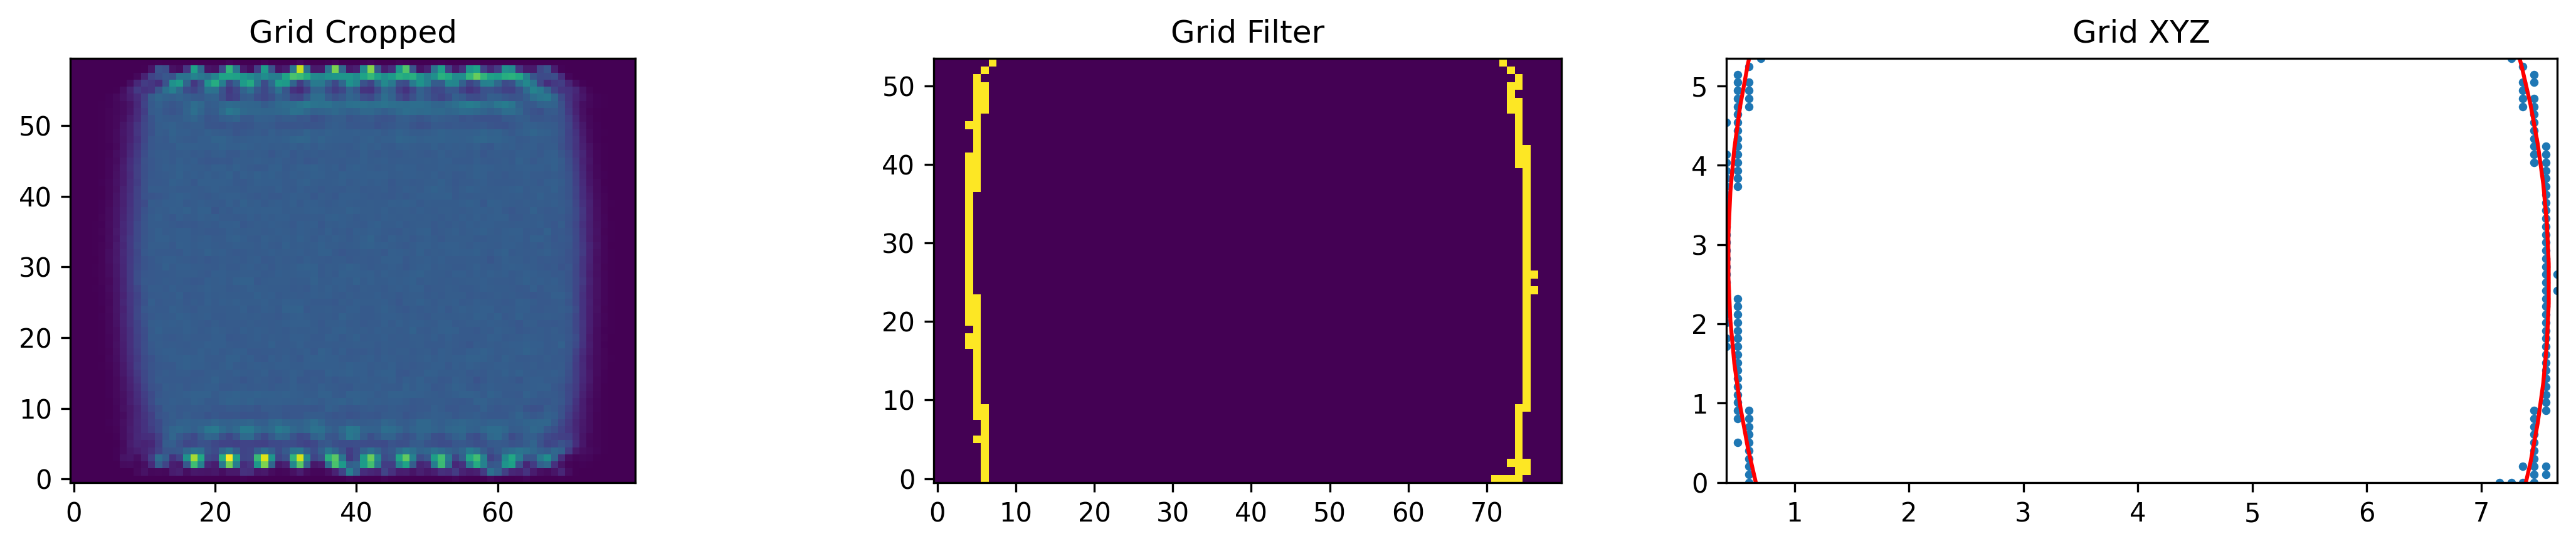

Chunk:   2%|▎         | 1/40 [01:04<41:46, 64.26s/it]

99.19370638596412


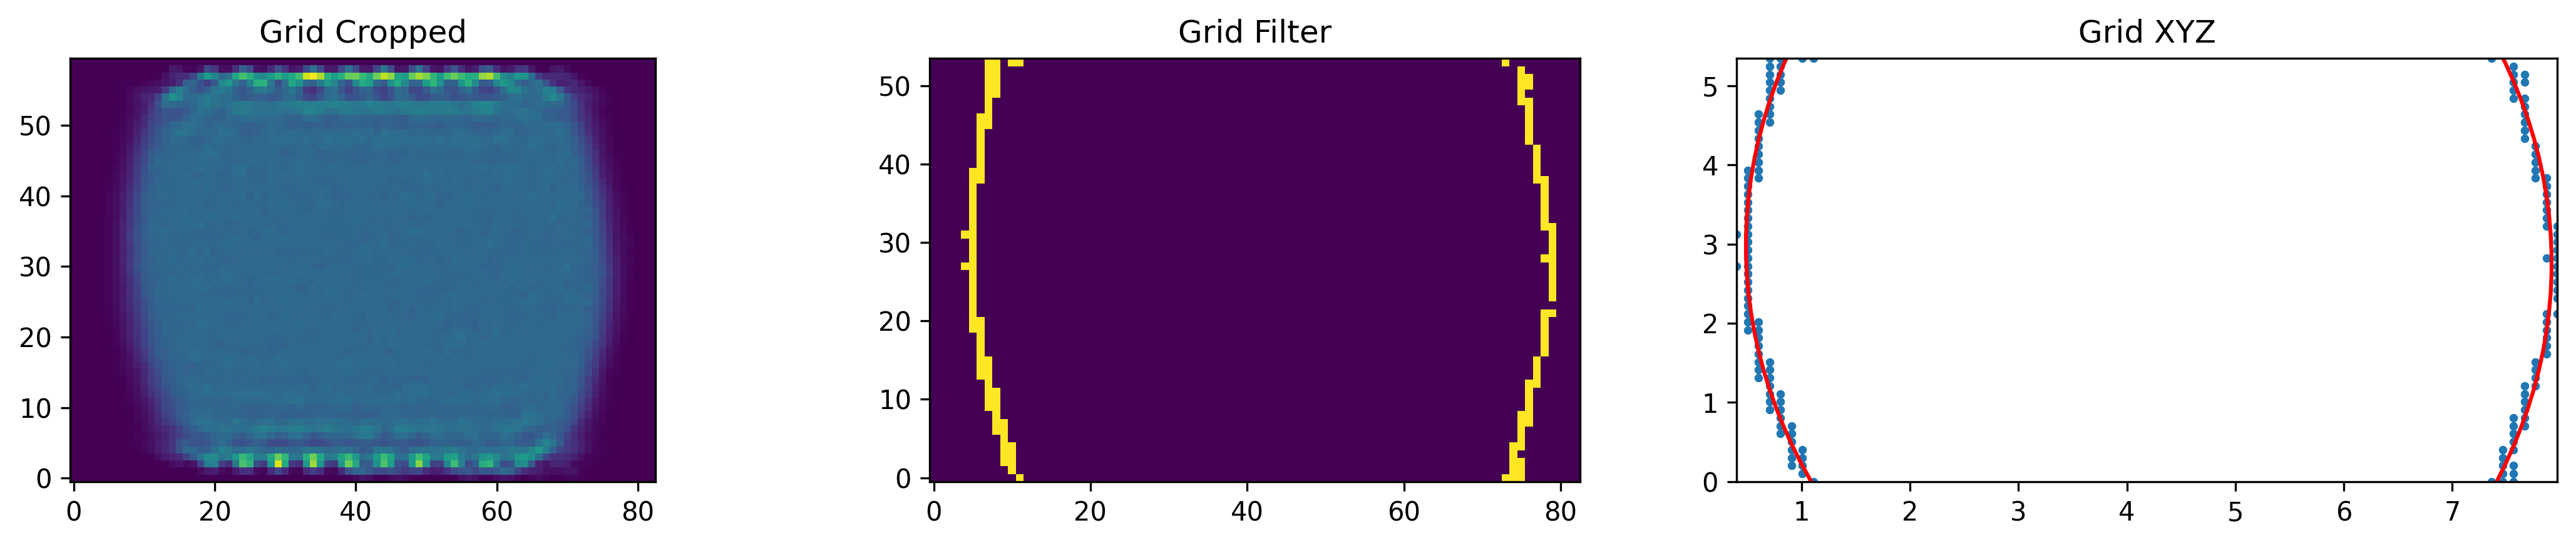

Chunk:   5%|▌         | 2/40 [01:11<19:20, 30.53s/it]

110.33330618493397


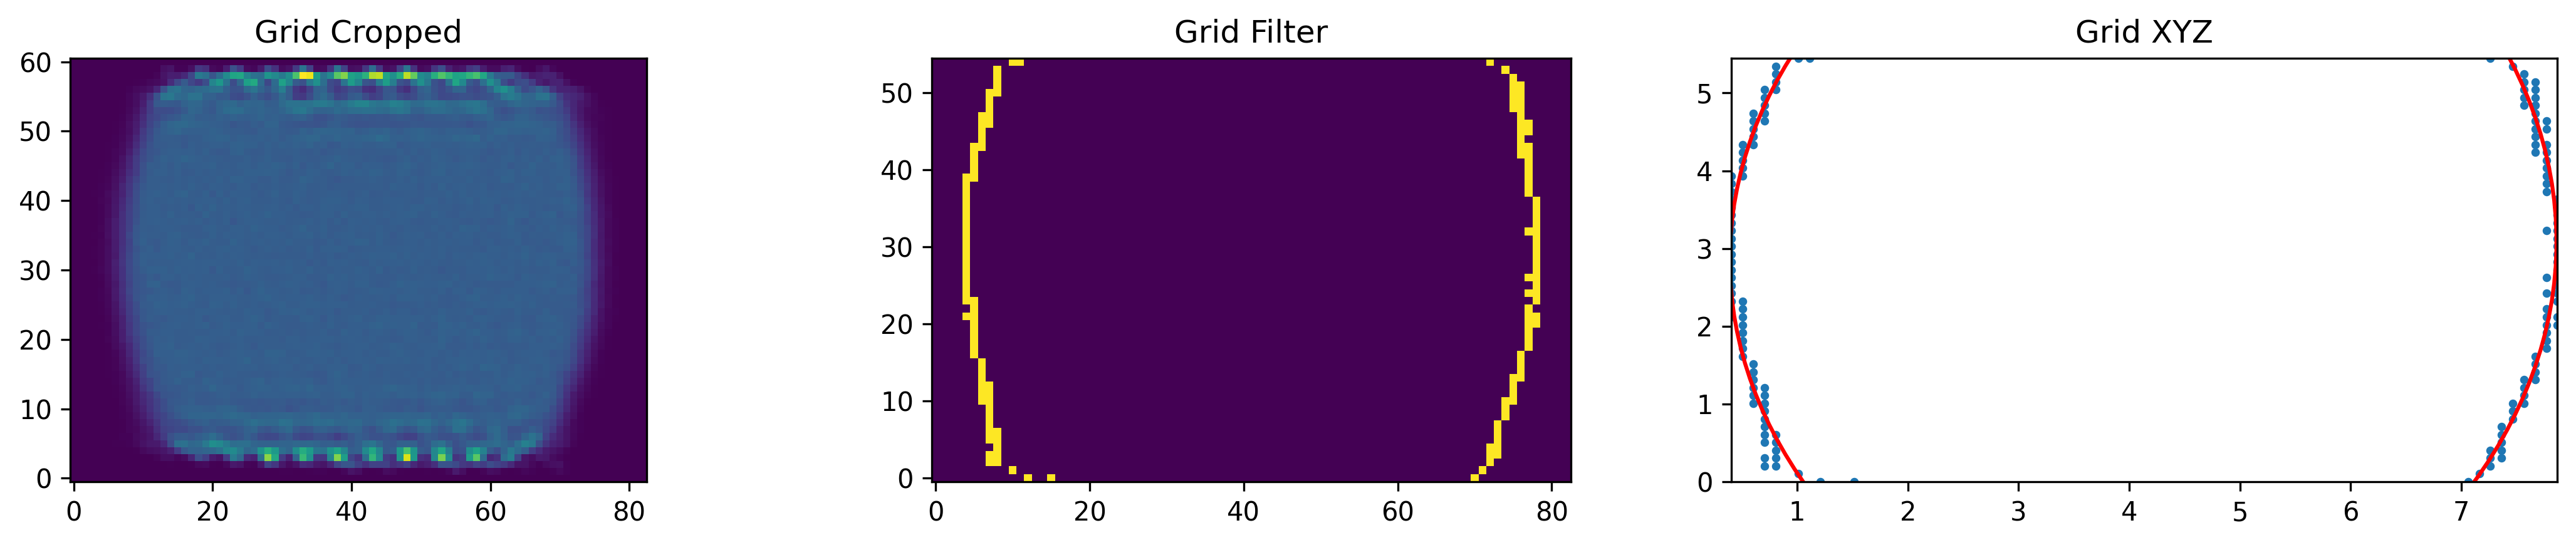

Chunk:   8%|▊         | 3/40 [01:18<12:16, 19.89s/it]

114.67752789895754


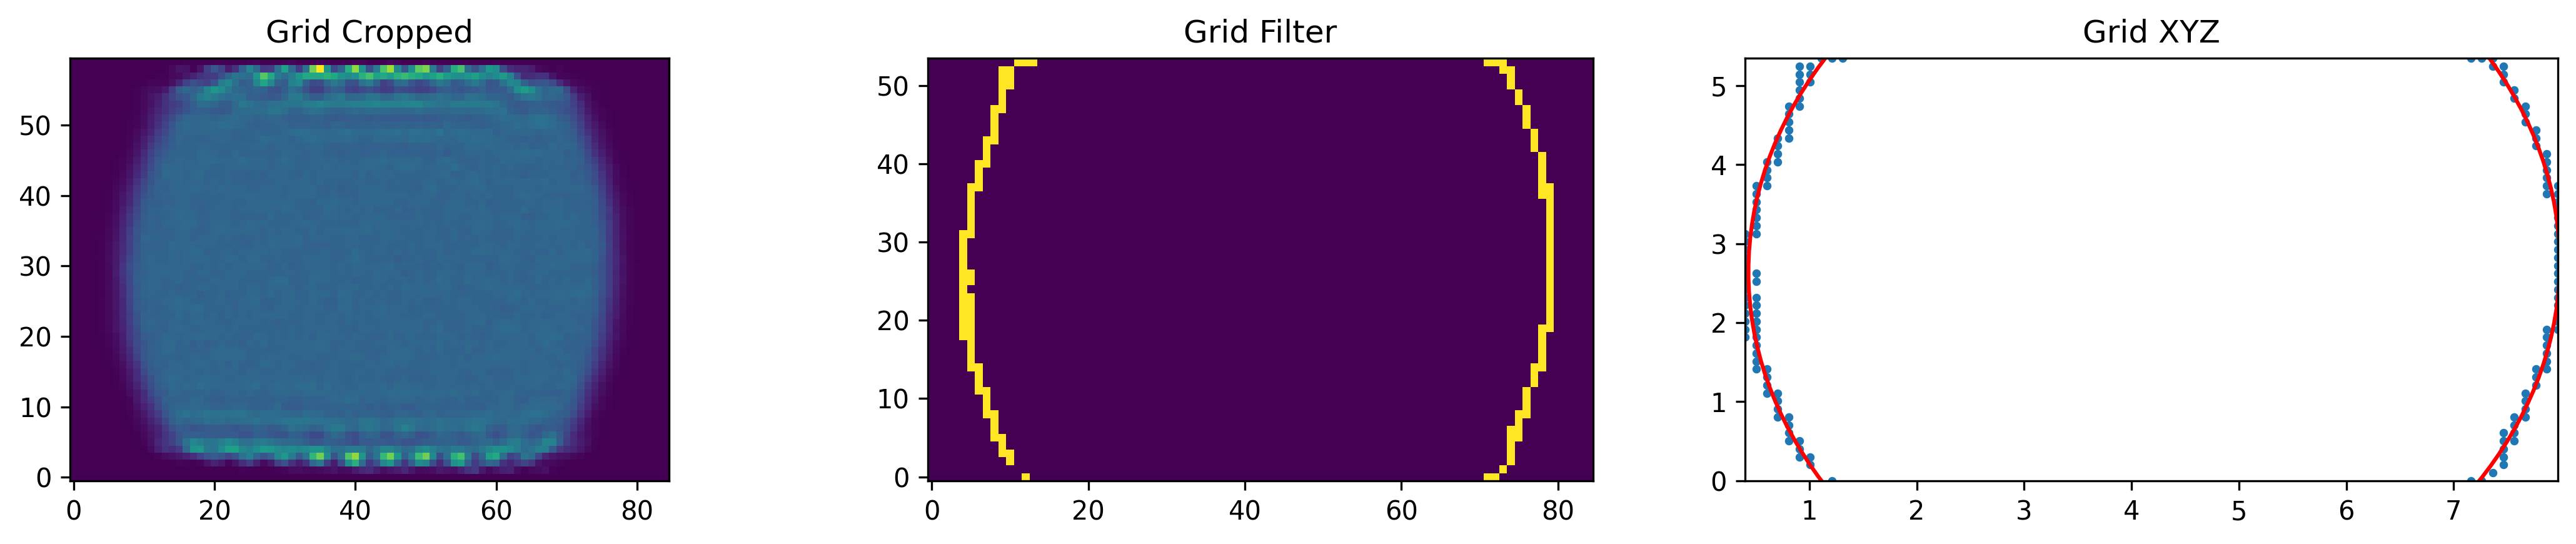

Chunk:  10%|█         | 4/40 [01:25<08:50, 14.75s/it]

119.30295067677773


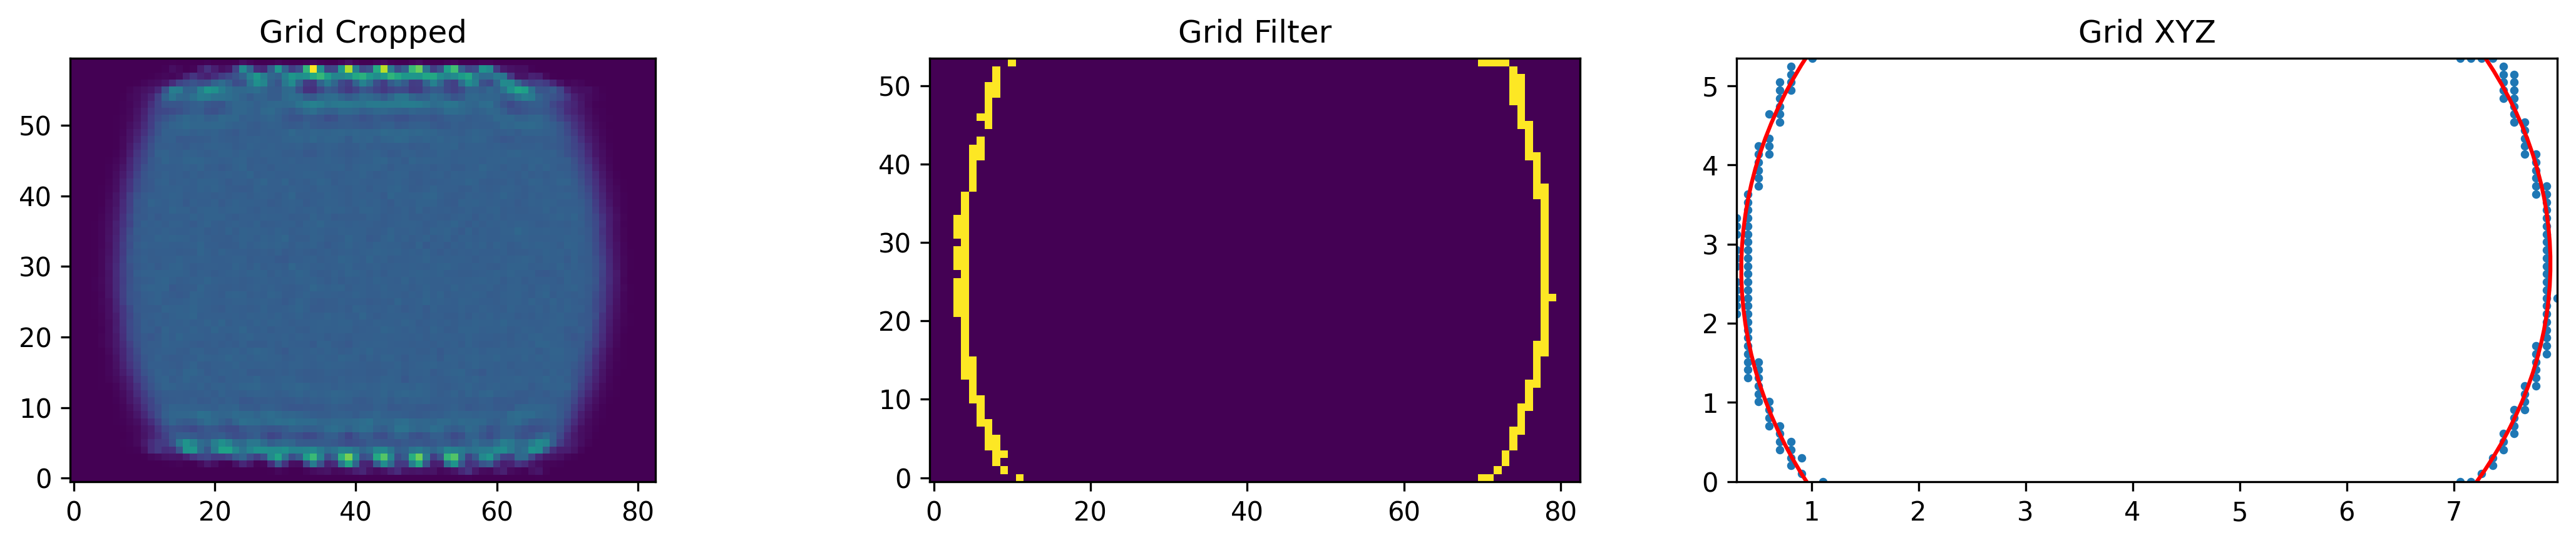

Chunk:  12%|█▎        | 5/40 [01:32<06:57, 11.94s/it]

115.92013038401318


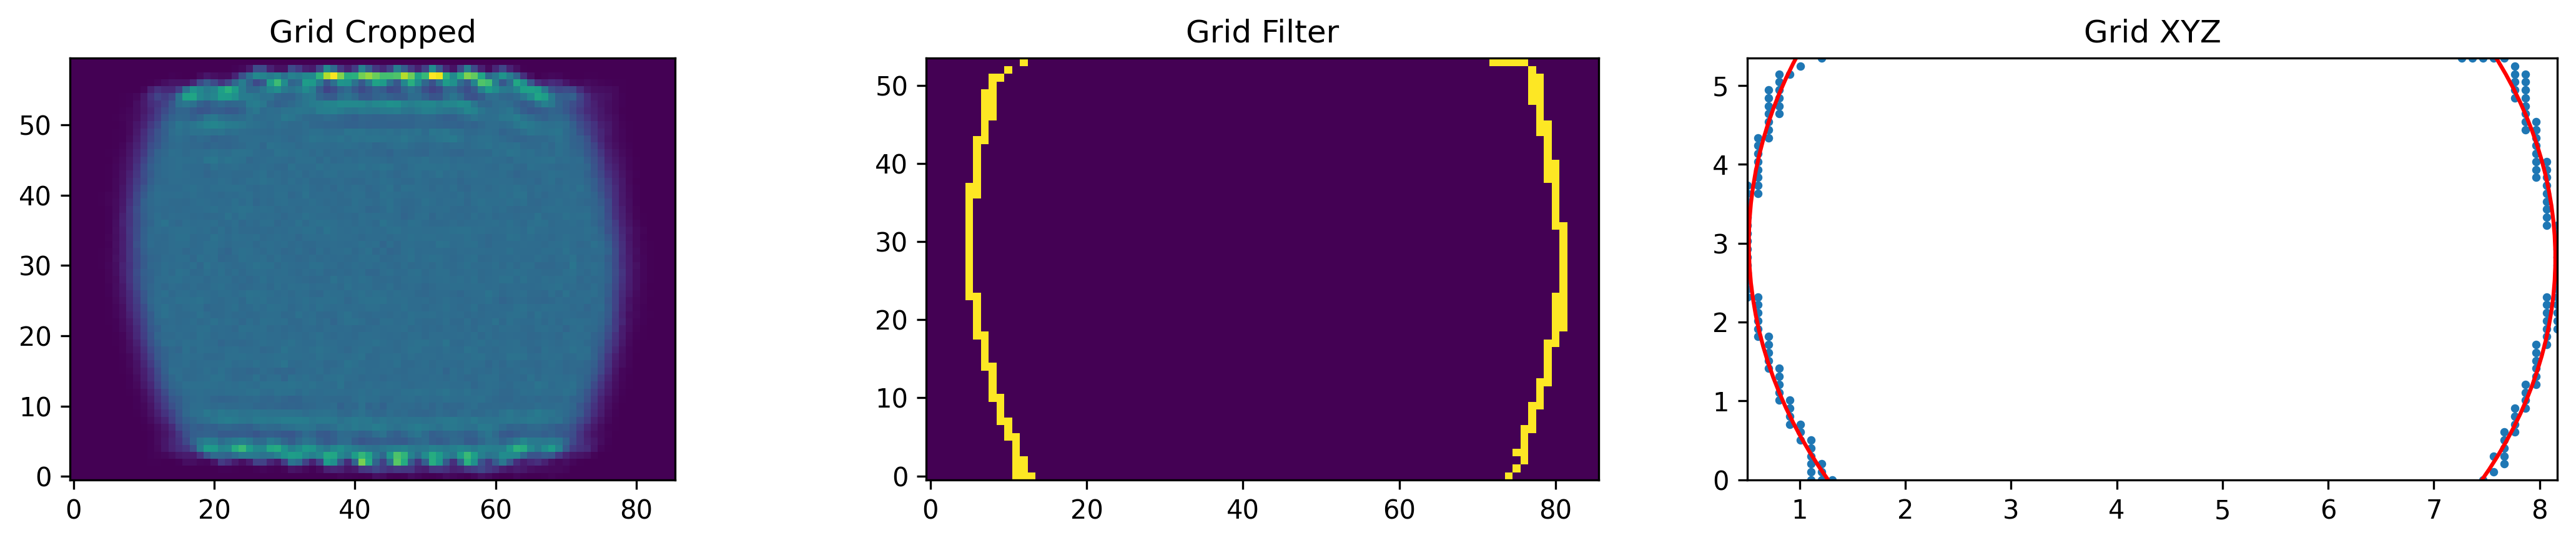

Chunk:  15%|█▌        | 6/40 [01:37<05:31,  9.74s/it]

115.1454153211435


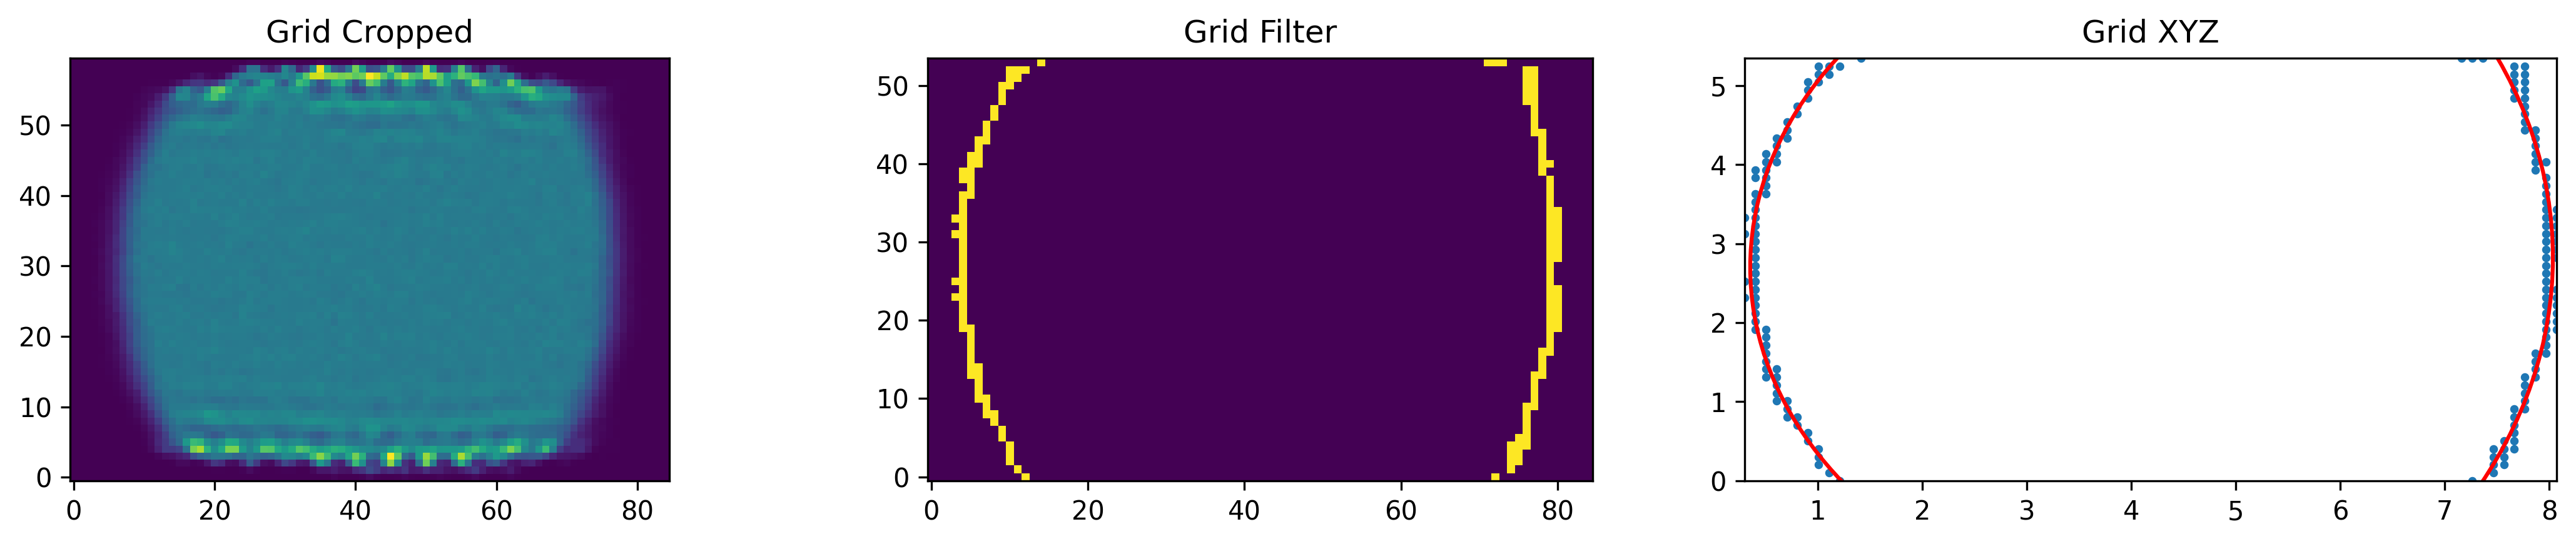

Chunk:  18%|█▊        | 7/40 [01:43<04:39,  8.47s/it]

123.0029327891285


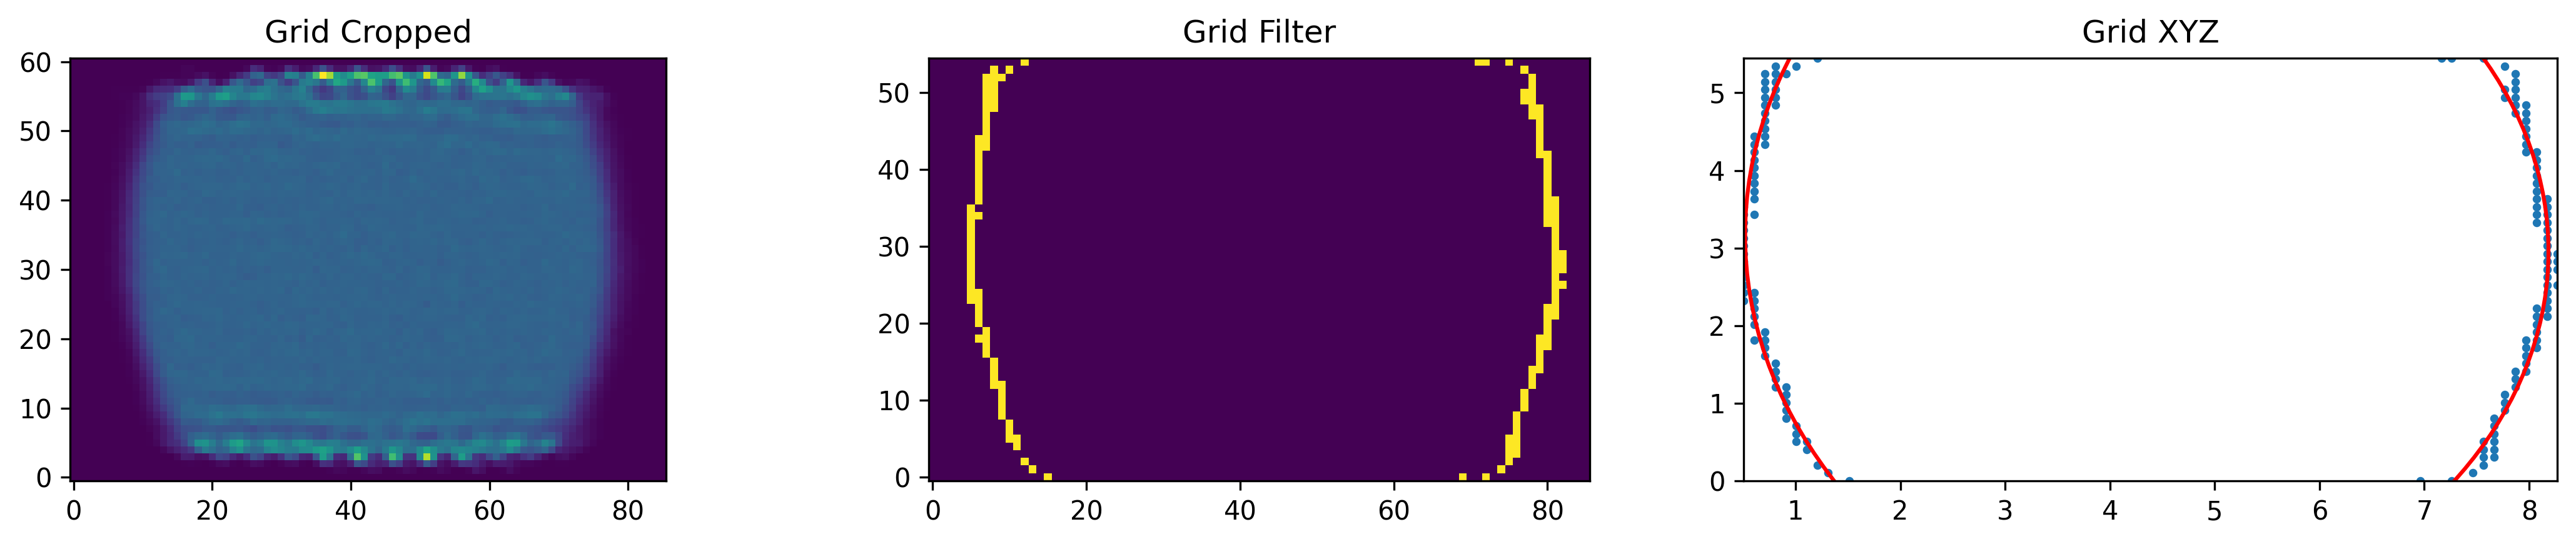

Chunk:  20%|██        | 8/40 [01:48<03:58,  7.46s/it]

116.75408167009884


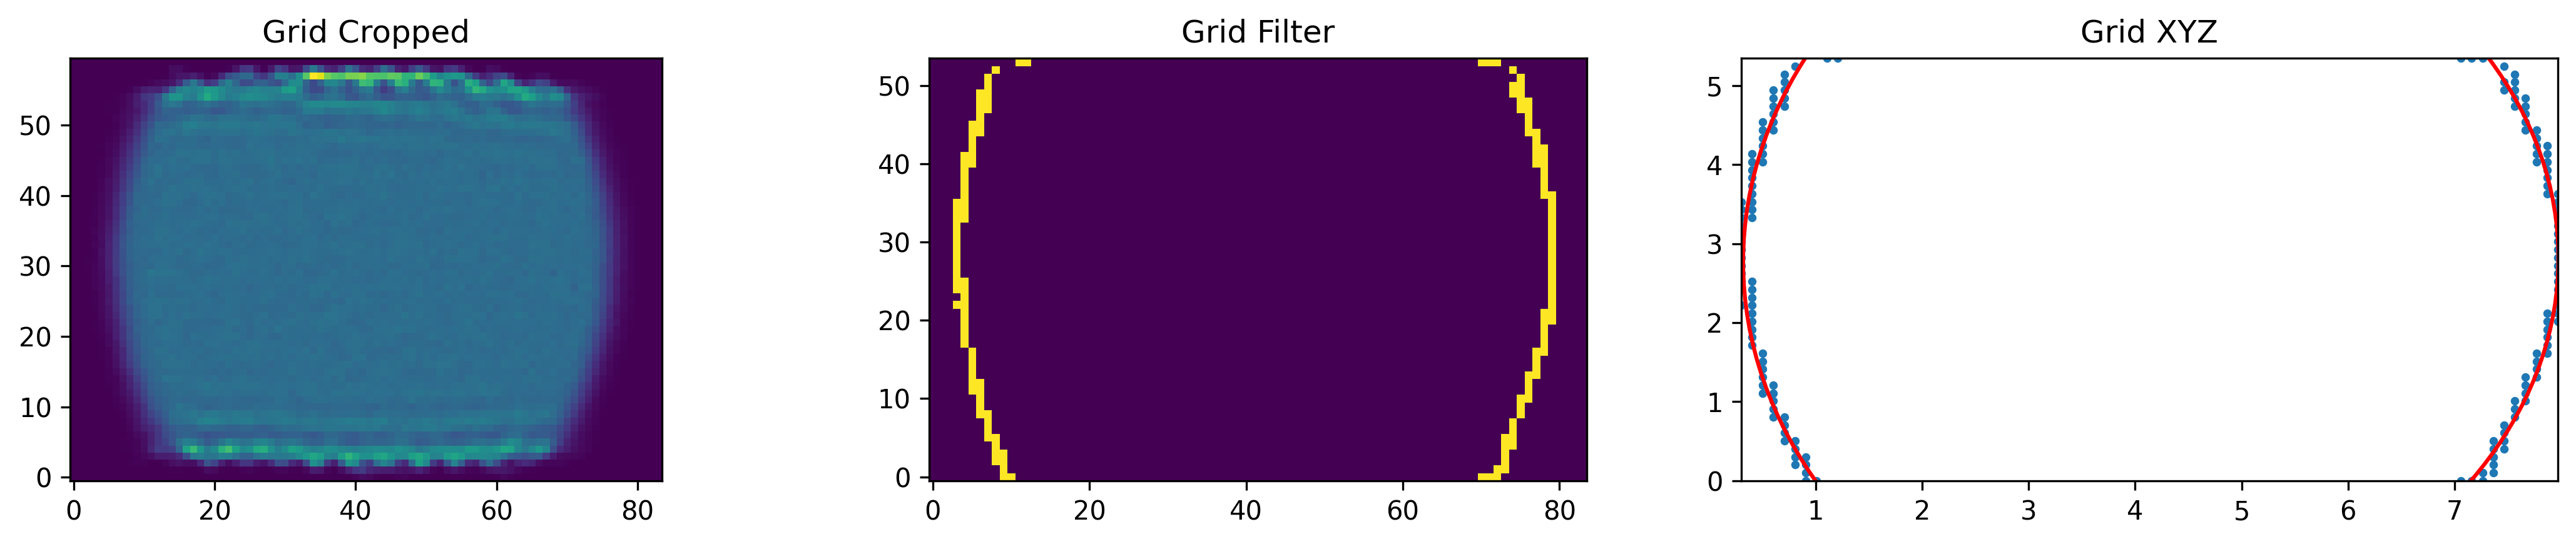

Chunk:  22%|██▎       | 9/40 [01:55<03:42,  7.16s/it]

117.51168670472157


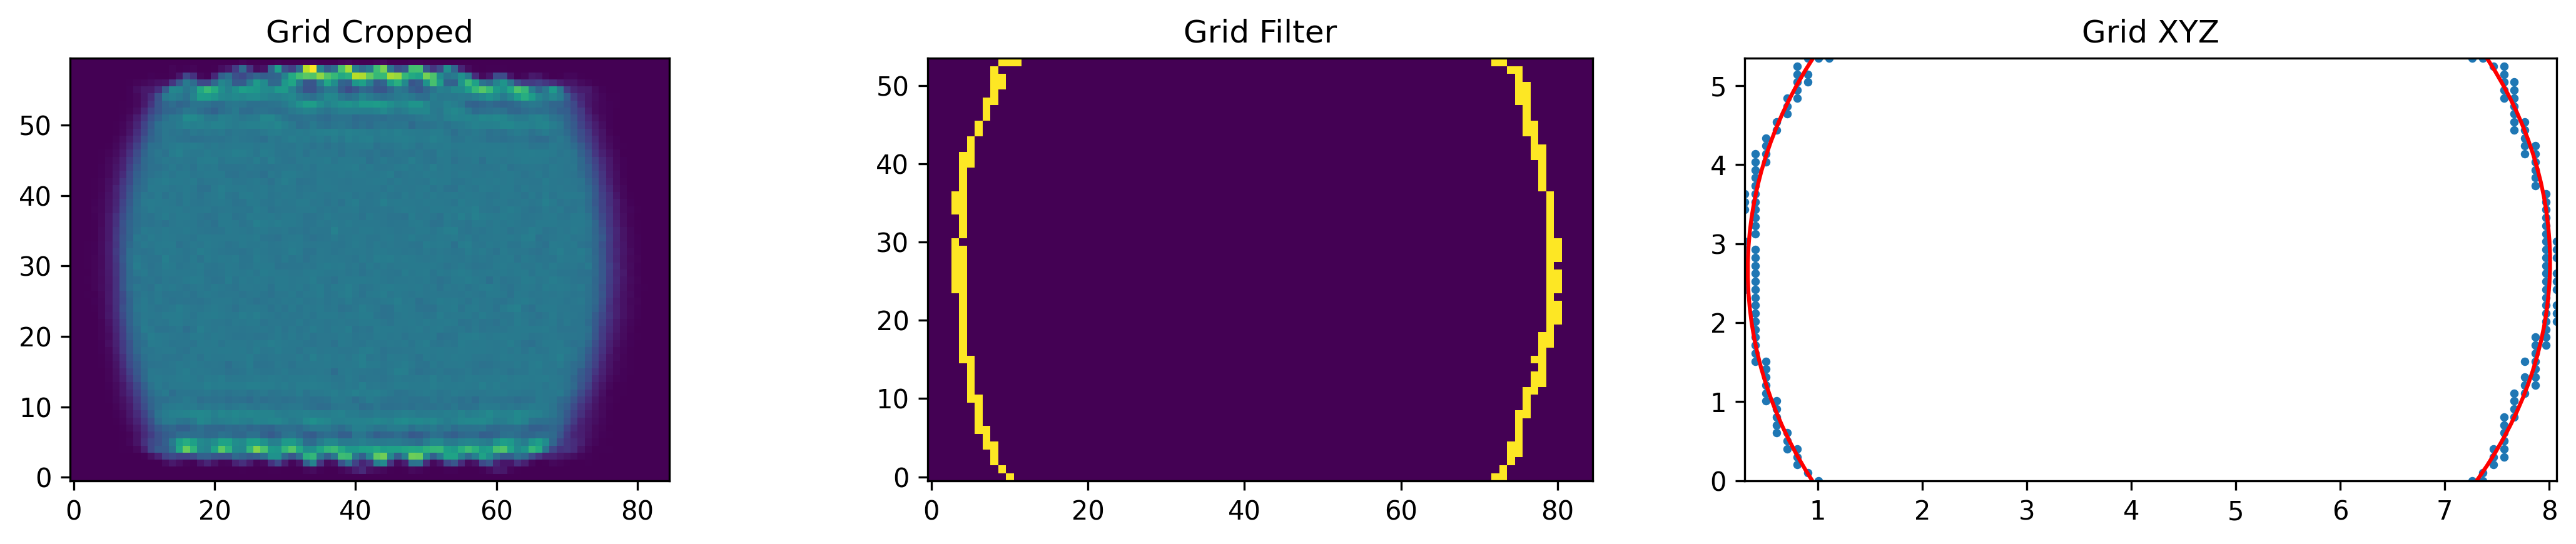

Chunk:  25%|██▌       | 10/40 [02:00<03:19,  6.65s/it]

116.4598222781171


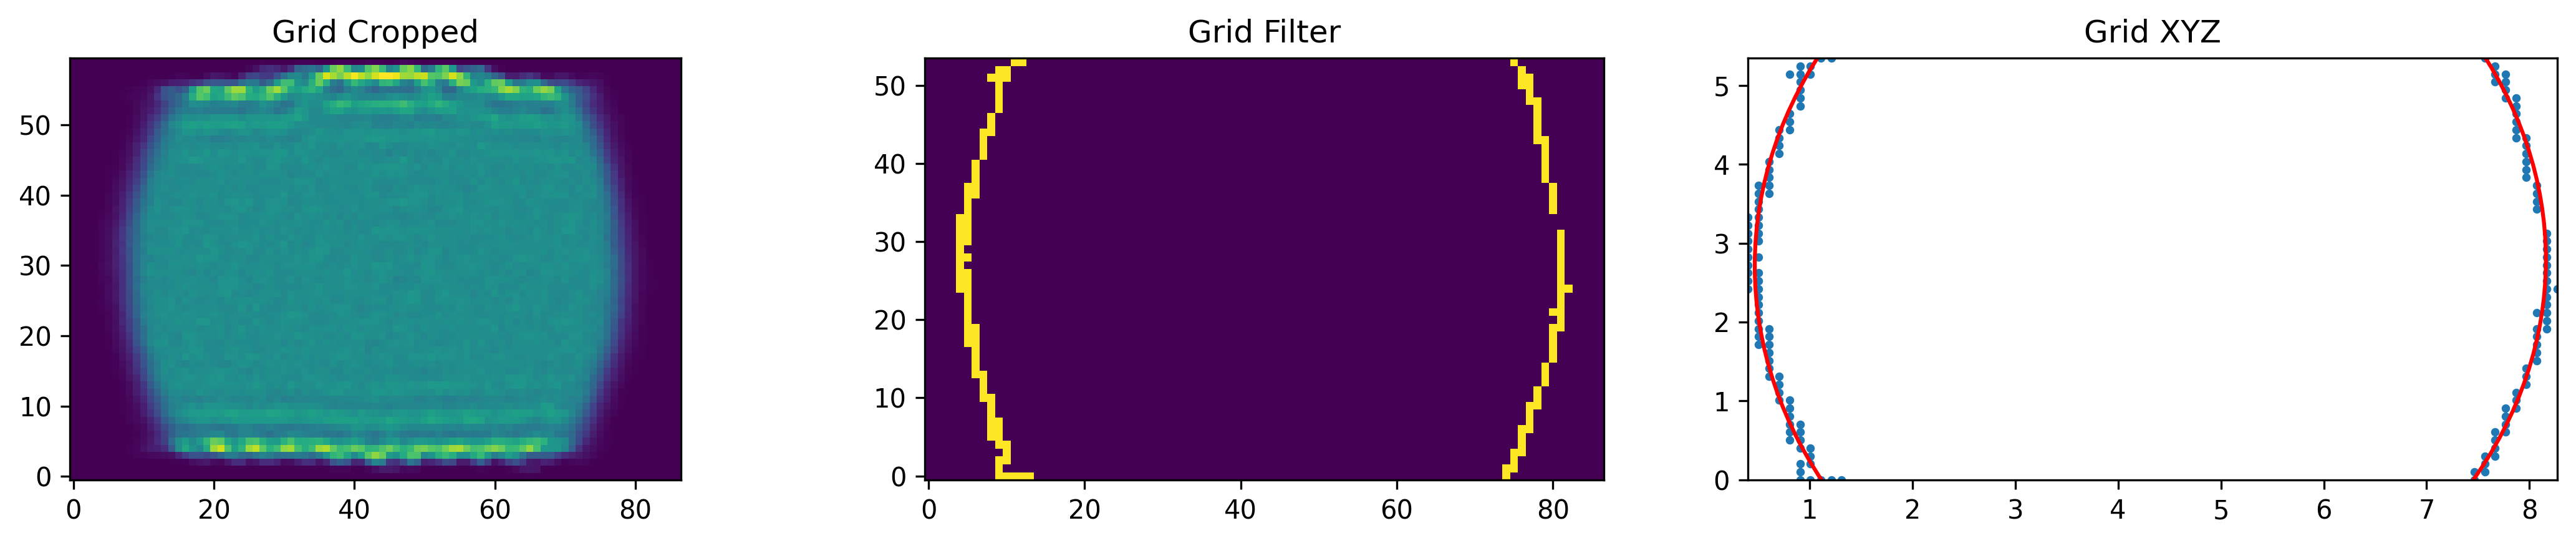

Chunk:  28%|██▊       | 11/40 [02:06<03:04,  6.36s/it]

116.61580644226476


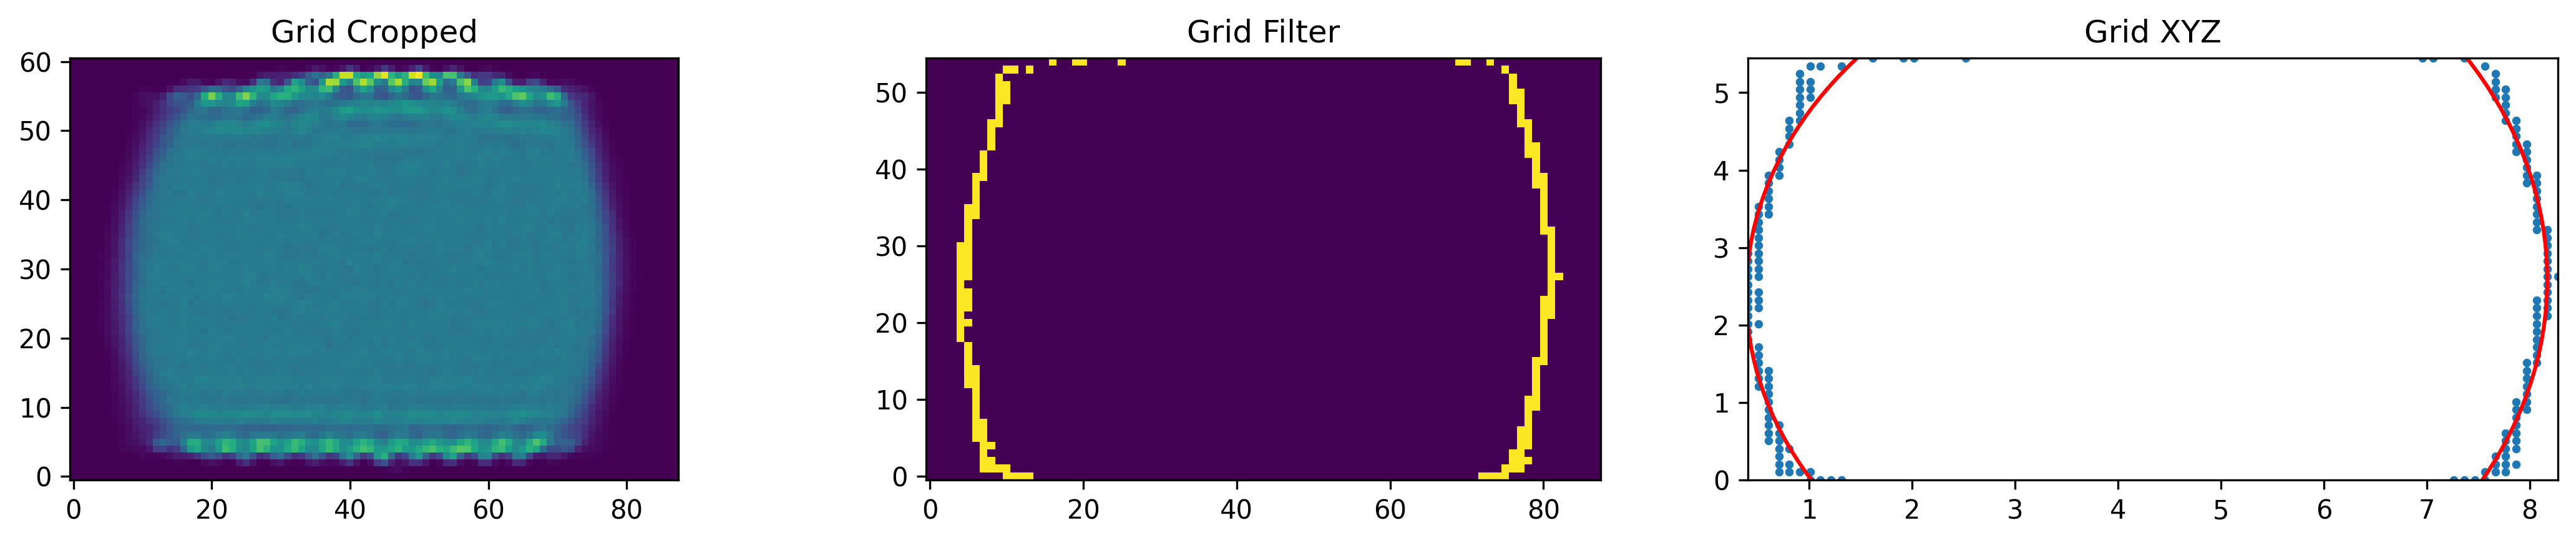

Chunk:  30%|███       | 12/40 [02:12<02:54,  6.24s/it]

122.81687461817317


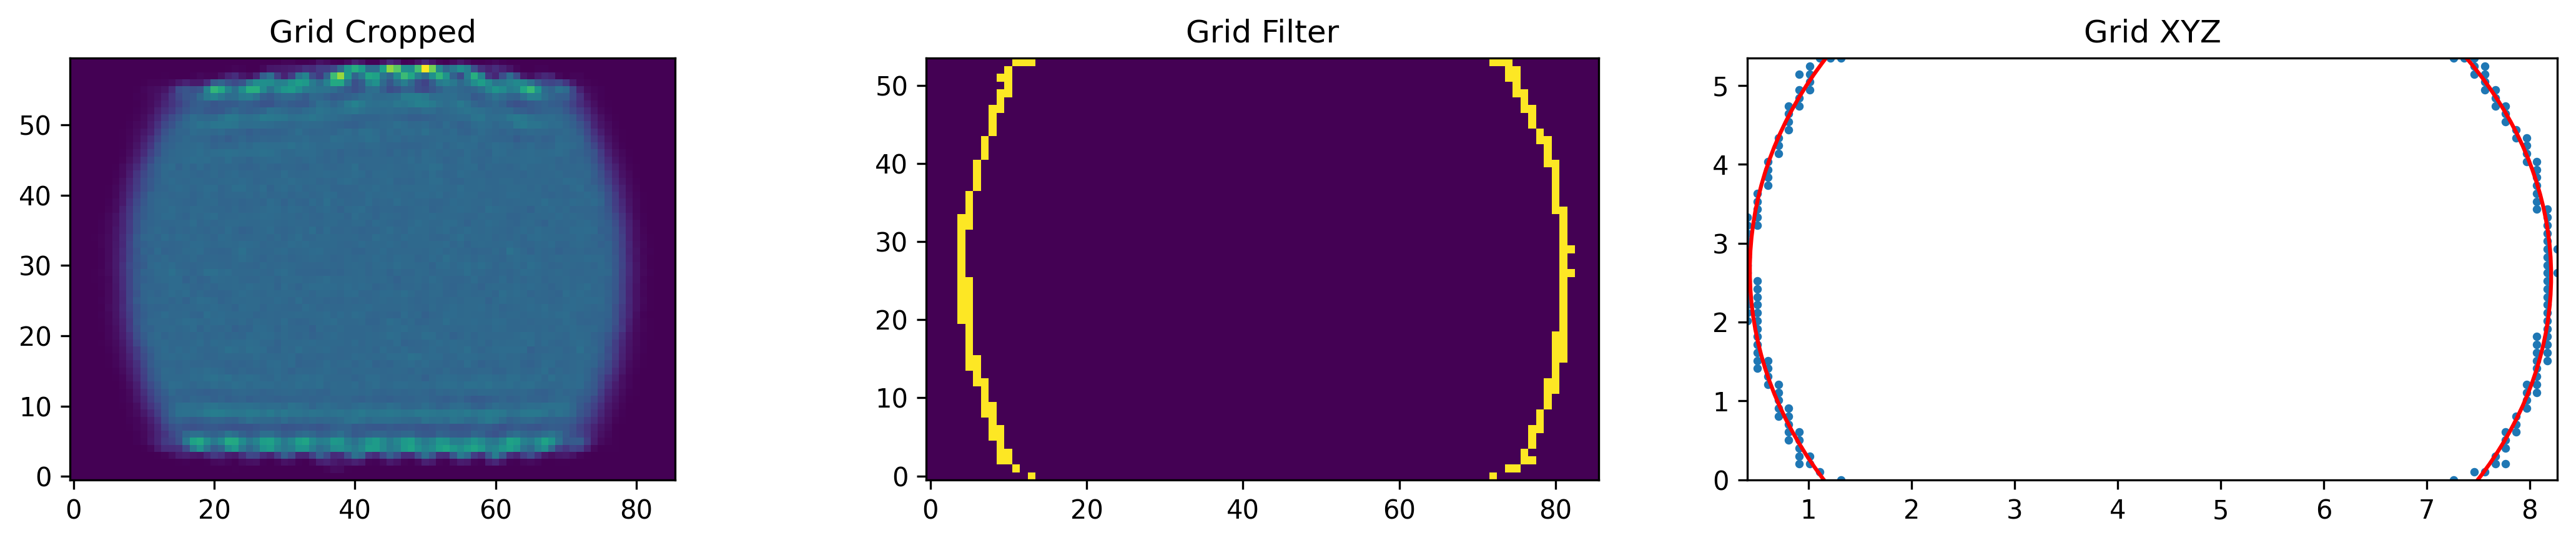

Chunk:  32%|███▎      | 13/40 [02:19<02:51,  6.36s/it]

120.88605410650798


Chunk:  35%|███▌      | 14/40 [02:26<02:52,  6.64s/it]

123.05784501986656


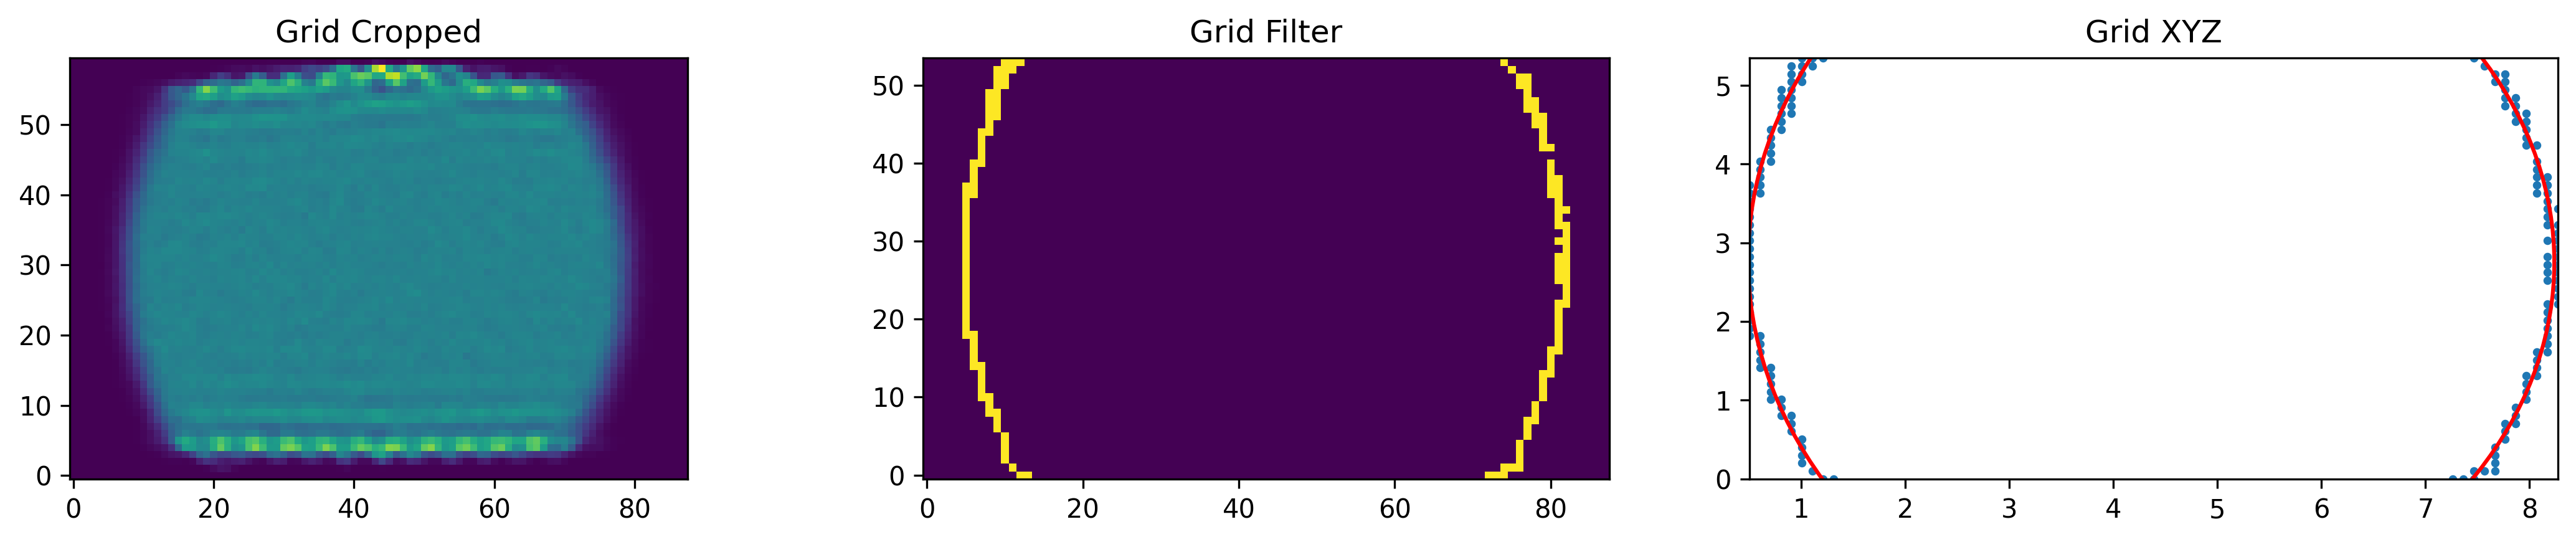

Chunk:  38%|███▊      | 15/40 [02:33<02:49,  6.76s/it]

118.43860281540896


Chunk:  40%|████      | 16/40 [02:40<02:46,  6.92s/it]

119.41877018655376


Chunk:  42%|████▎     | 17/40 [02:49<02:49,  7.35s/it]

115.70299577459345


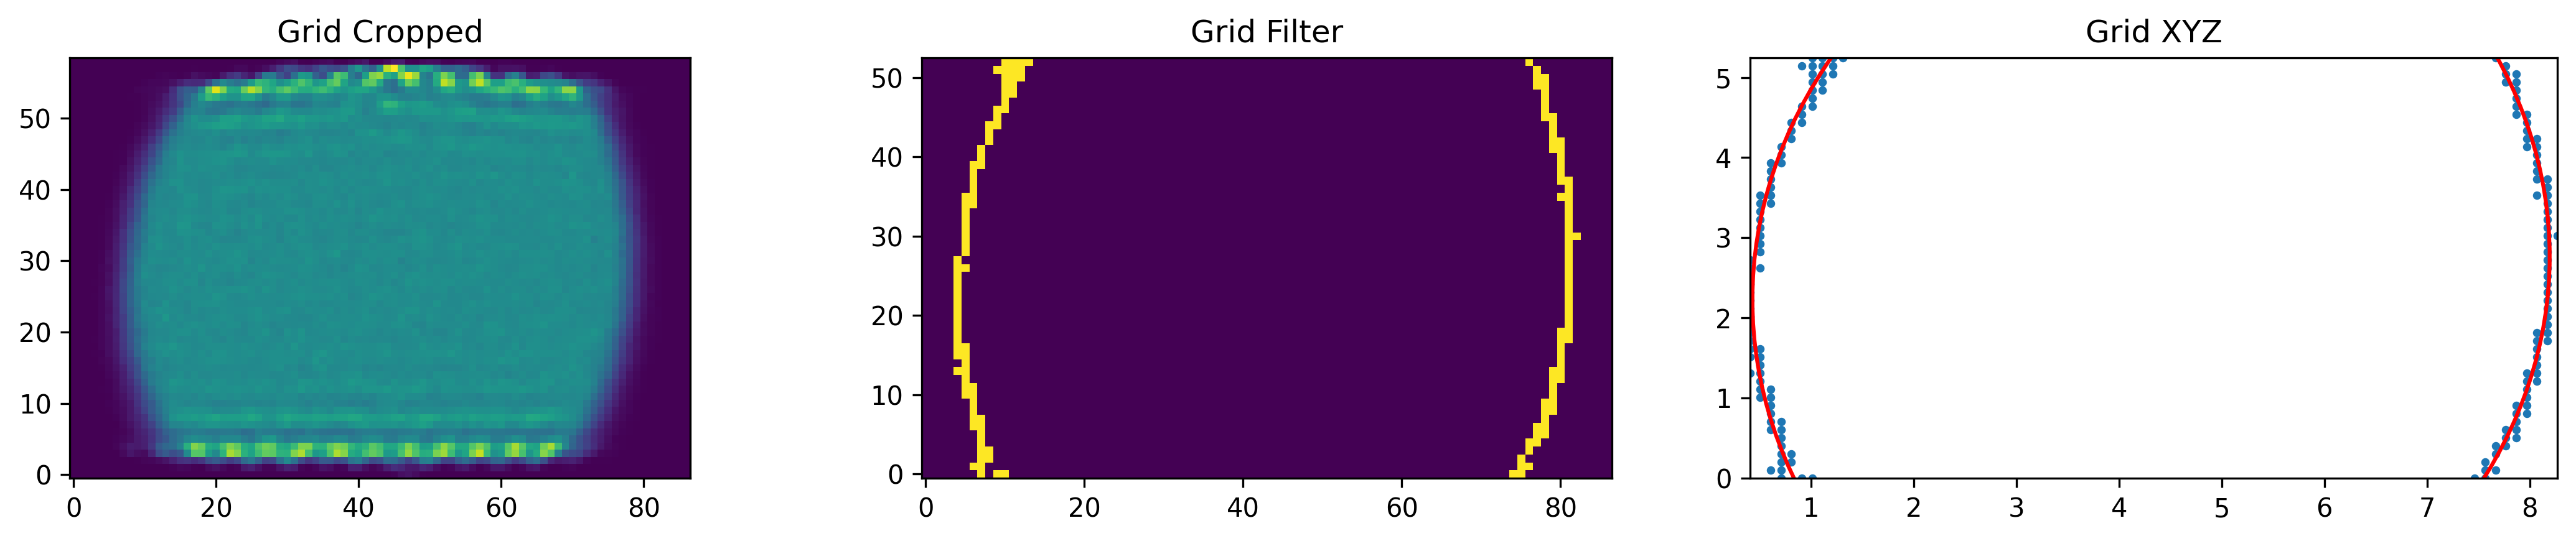

Chunk:  45%|████▌     | 18/40 [02:56<02:39,  7.24s/it]

114.54749111502719


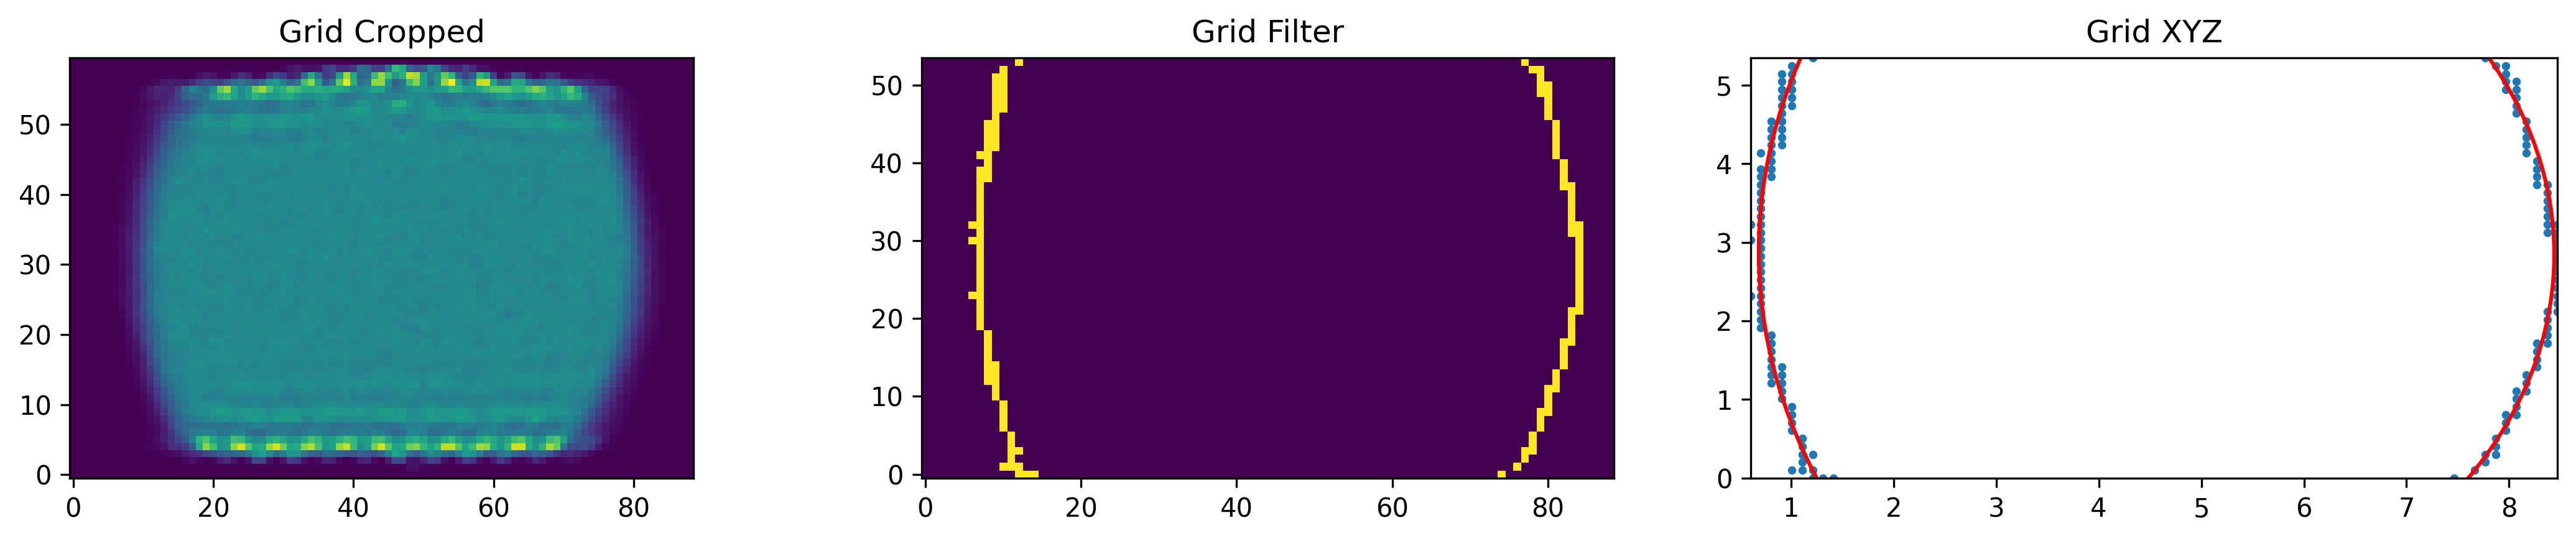

Chunk:  48%|████▊     | 19/40 [03:03<02:35,  7.41s/it]

112.86167125815153


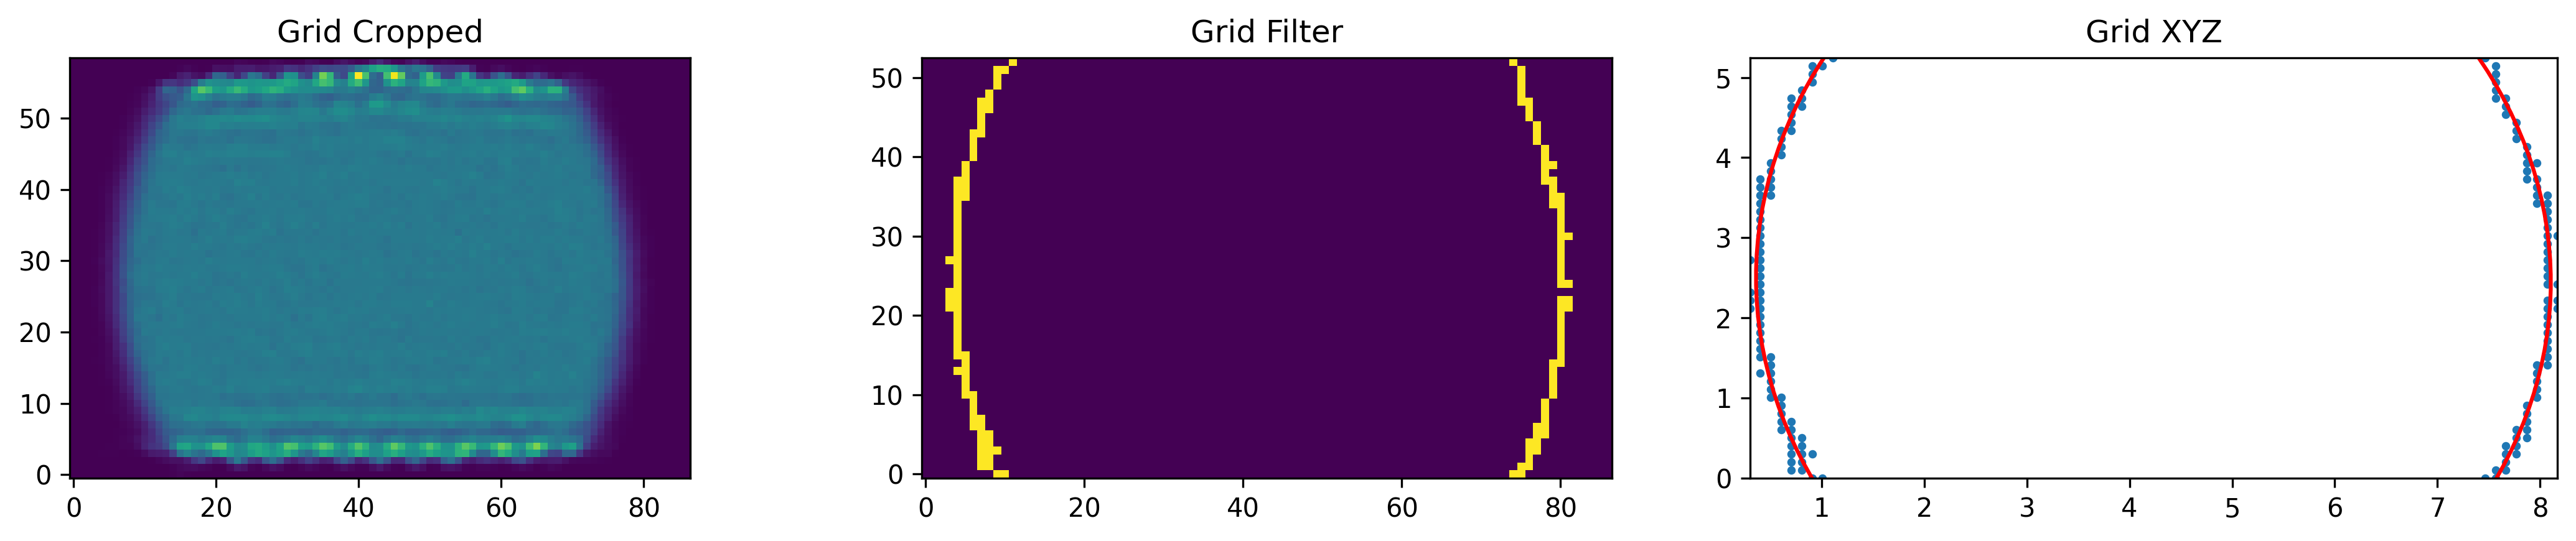

Chunk:  50%|█████     | 20/40 [03:11<02:27,  7.37s/it]

115.95860023887207


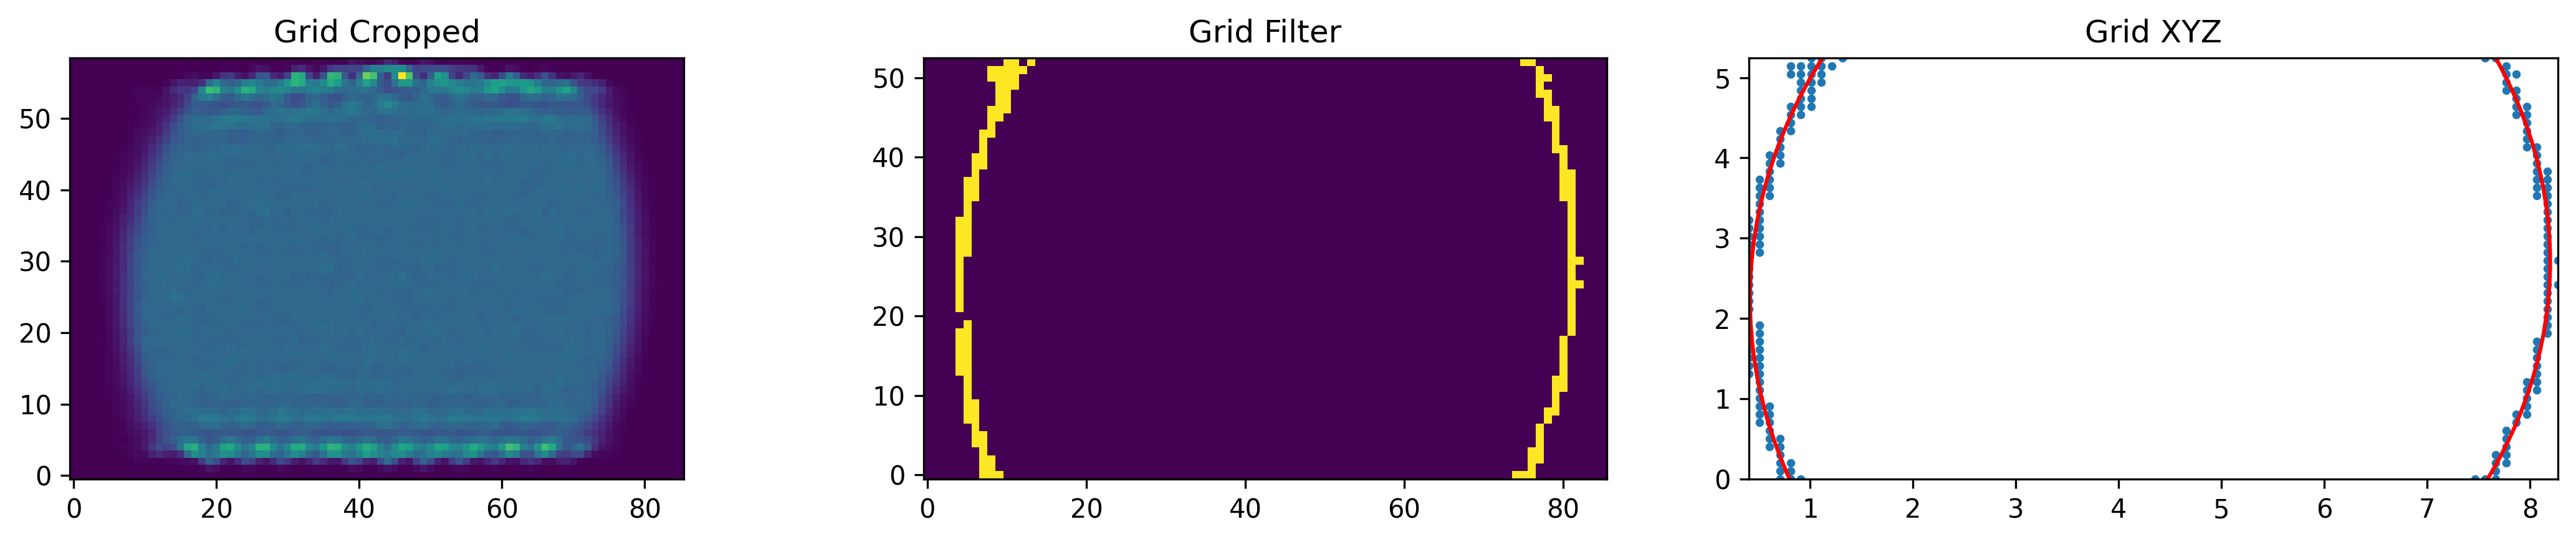

Chunk:  52%|█████▎    | 21/40 [03:18<02:19,  7.33s/it]

113.31262455906405


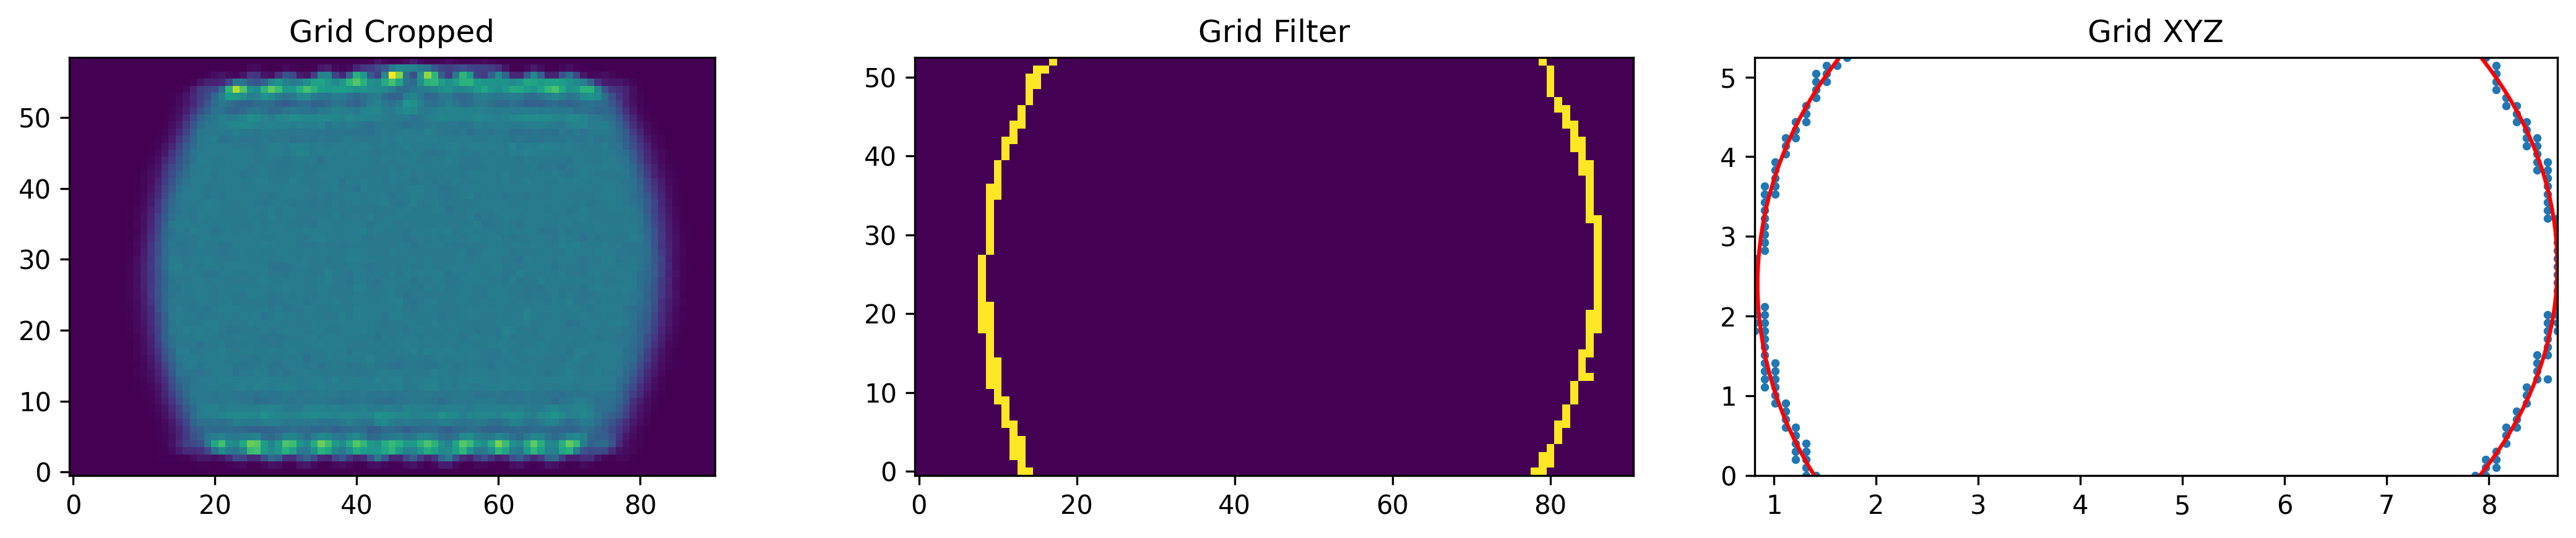

Chunk:  55%|█████▌    | 22/40 [03:27<02:19,  7.76s/it]

119.57817078197495


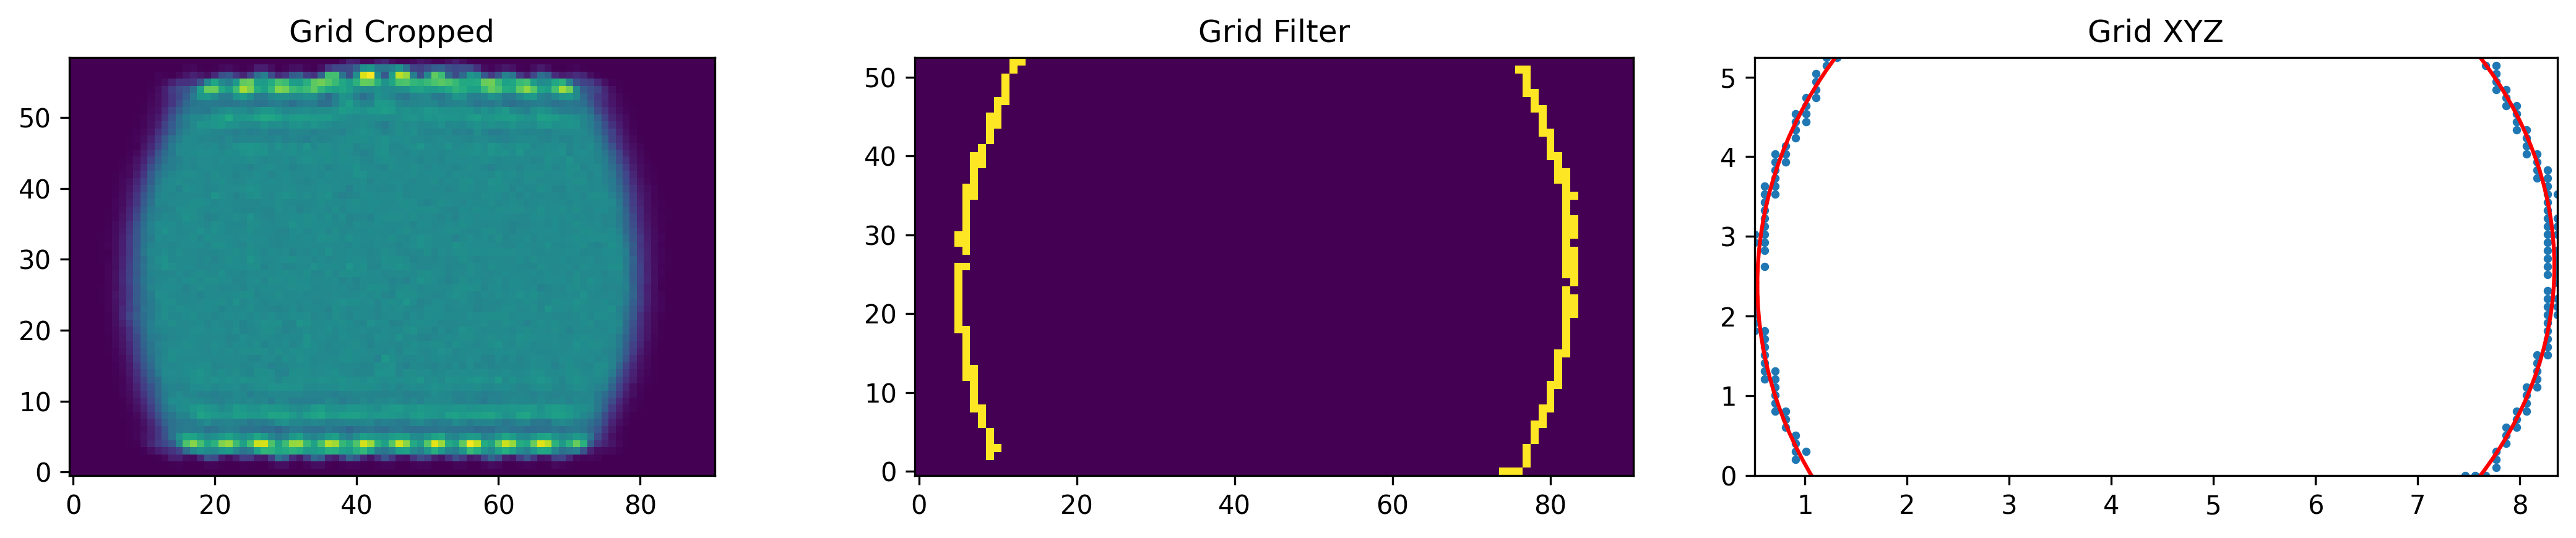

Chunk:  57%|█████▊    | 23/40 [03:33<02:06,  7.47s/it]

118.32620229380925


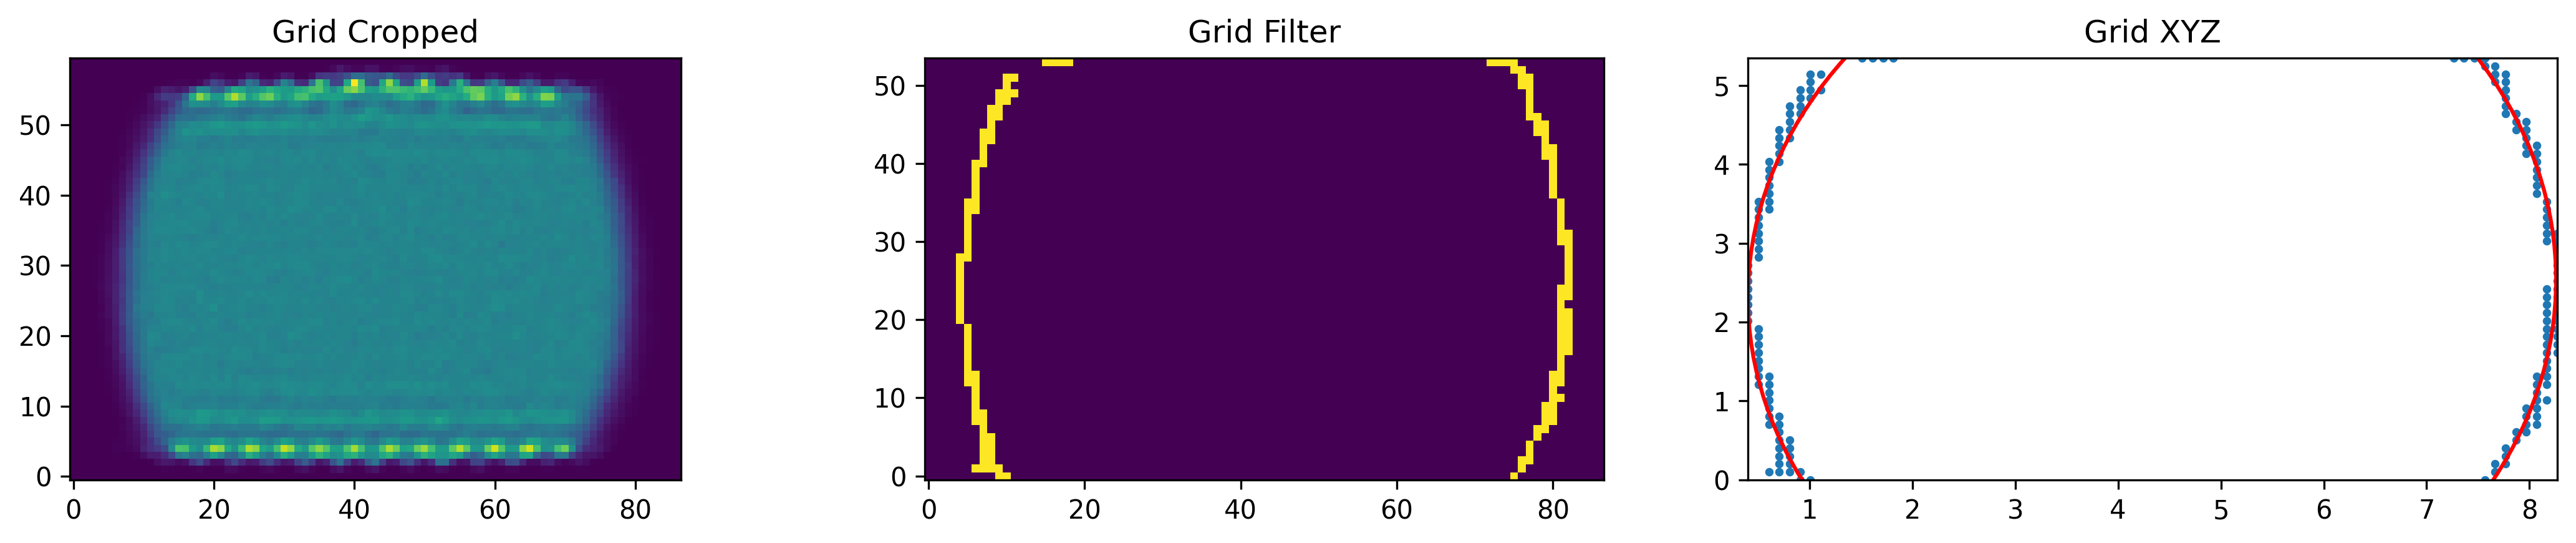

Chunk:  60%|██████    | 24/40 [03:42<02:02,  7.64s/it]

119.72951868380736


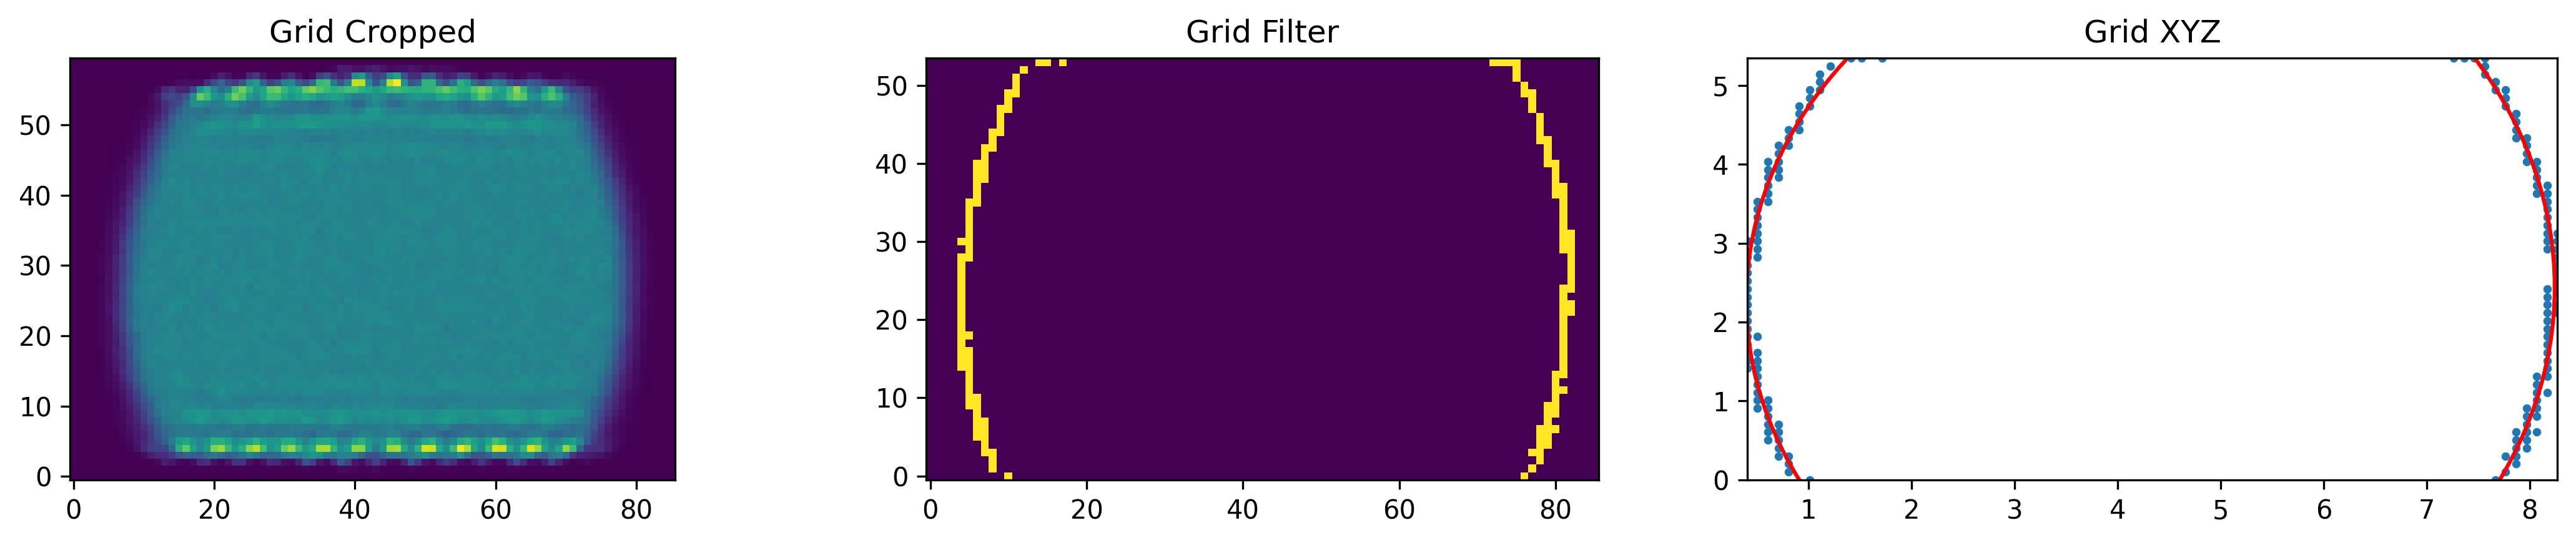

Chunk:  62%|██████▎   | 25/40 [03:49<01:55,  7.67s/it]

119.5858243268357


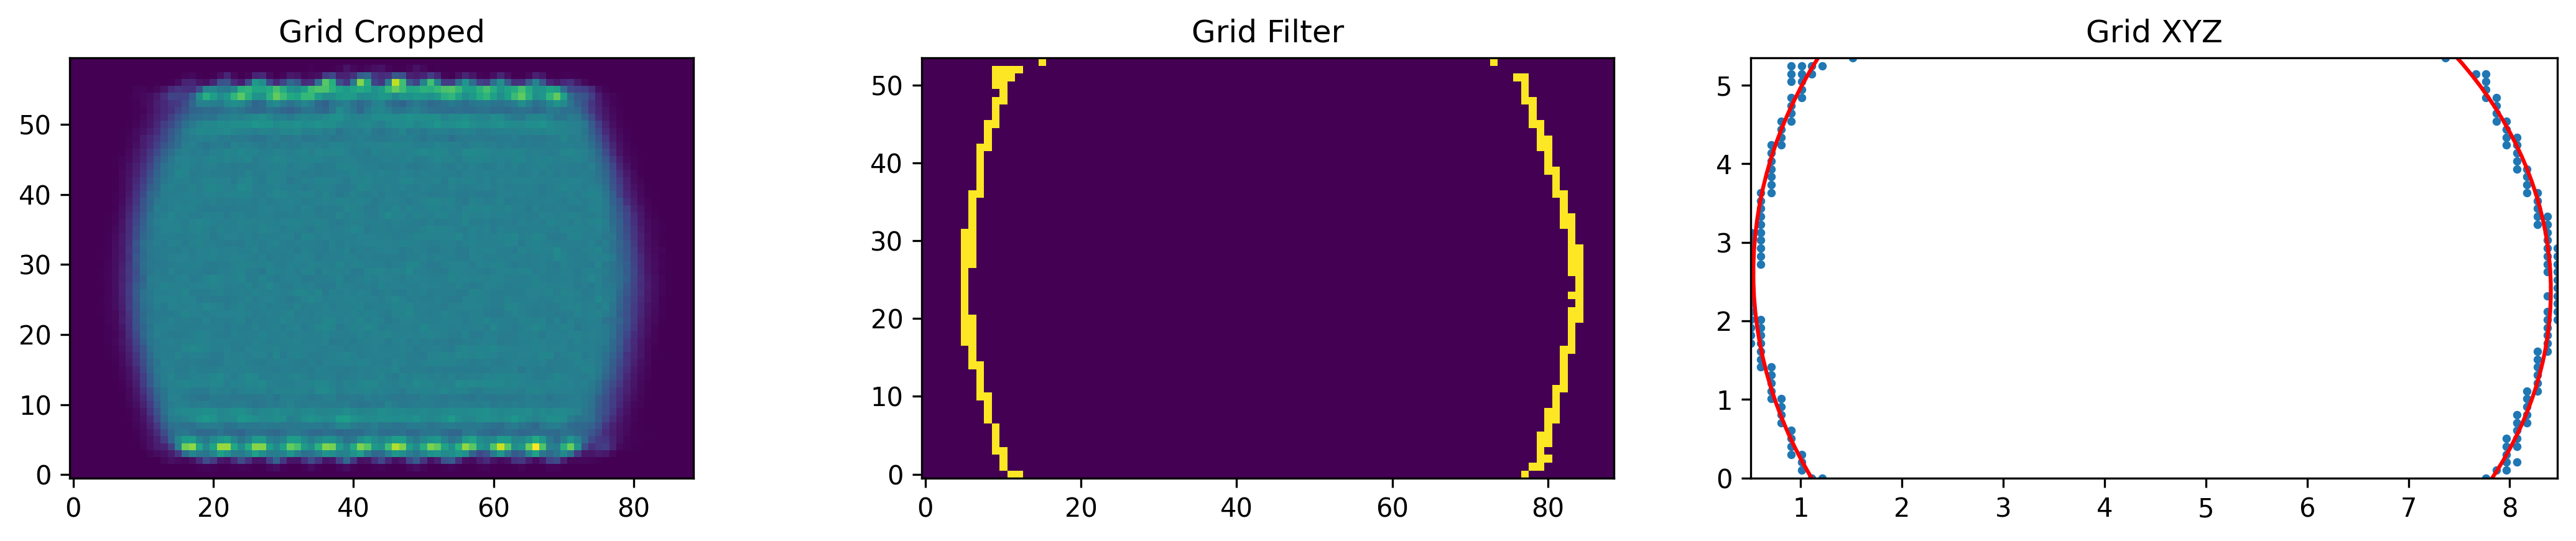

Chunk:  65%|██████▌   | 26/40 [03:57<01:48,  7.76s/it]

117.13279260282344


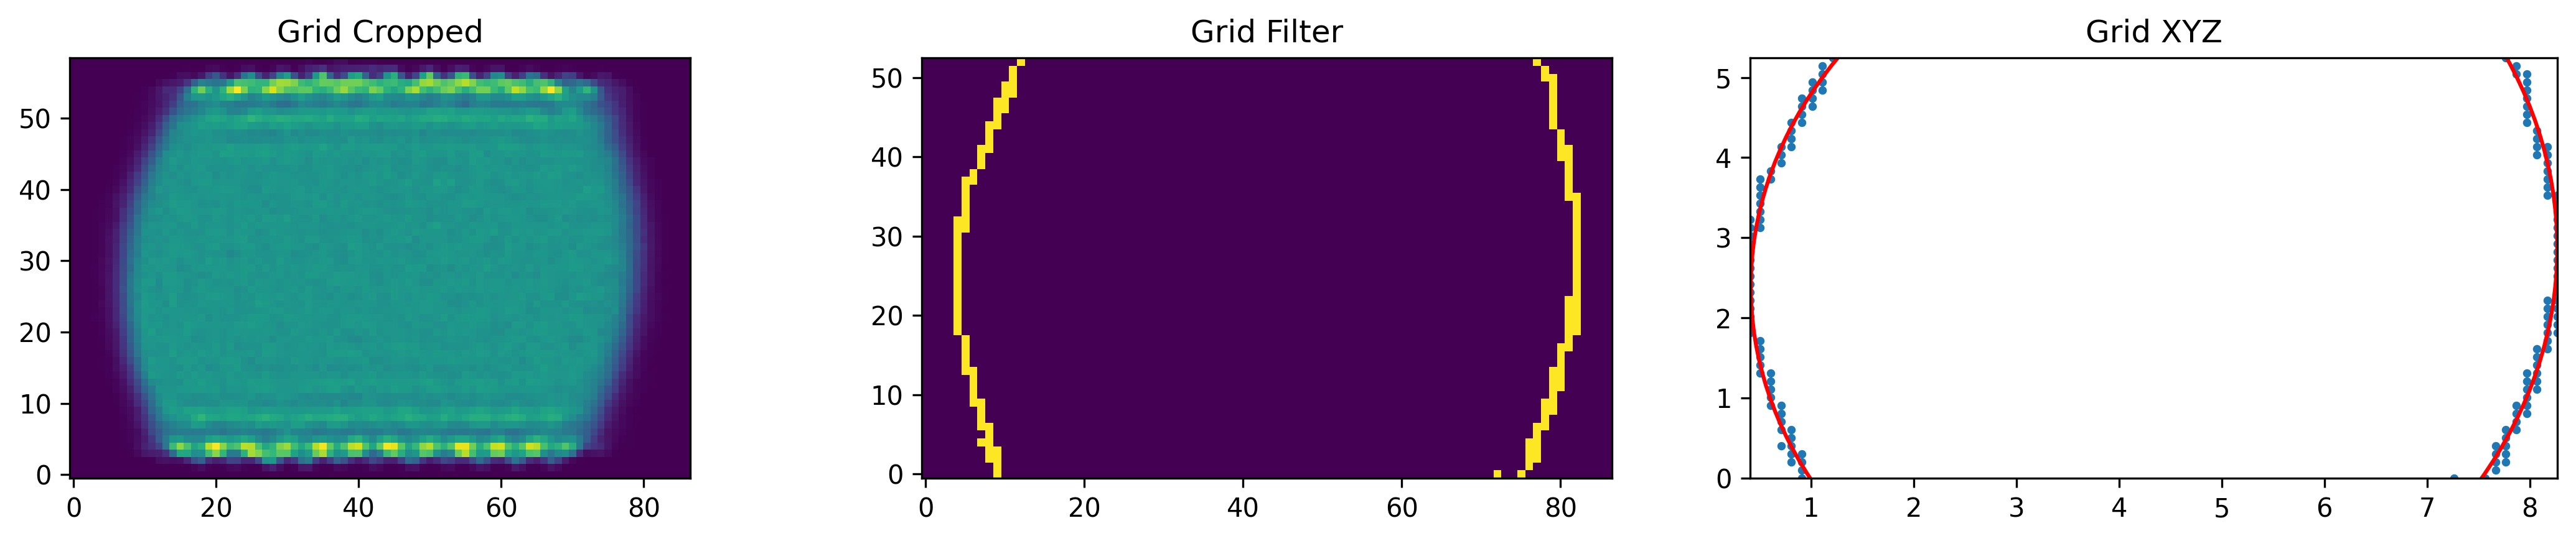

Chunk:  68%|██████▊   | 27/40 [04:04<01:37,  7.52s/it]

119.22404596651306


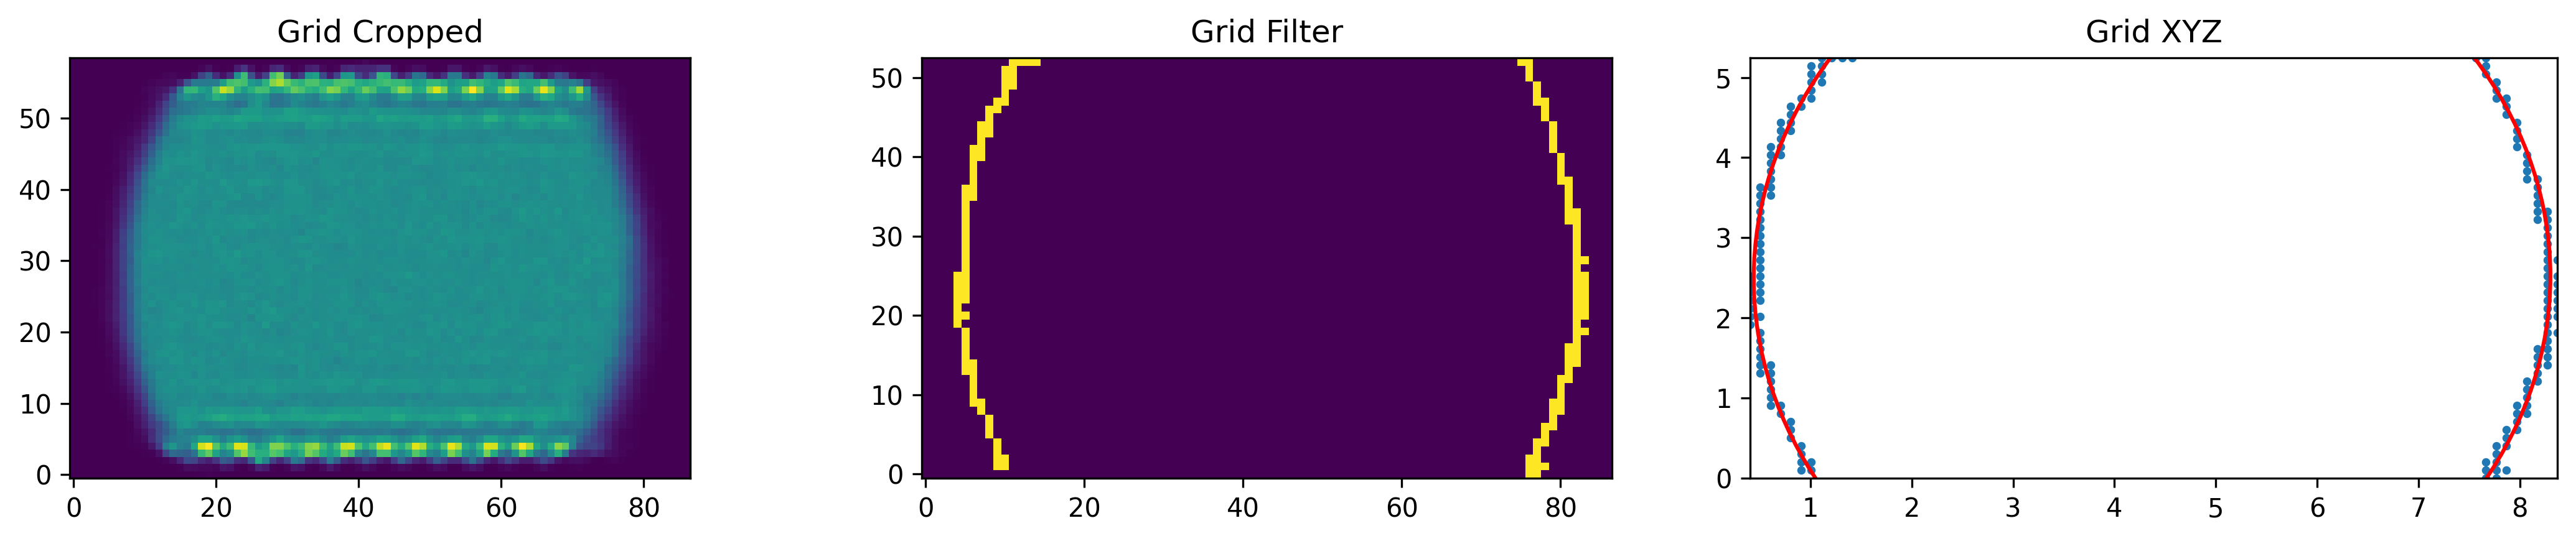

Chunk:  70%|███████   | 28/40 [04:11<01:29,  7.44s/it]

119.18288544290183


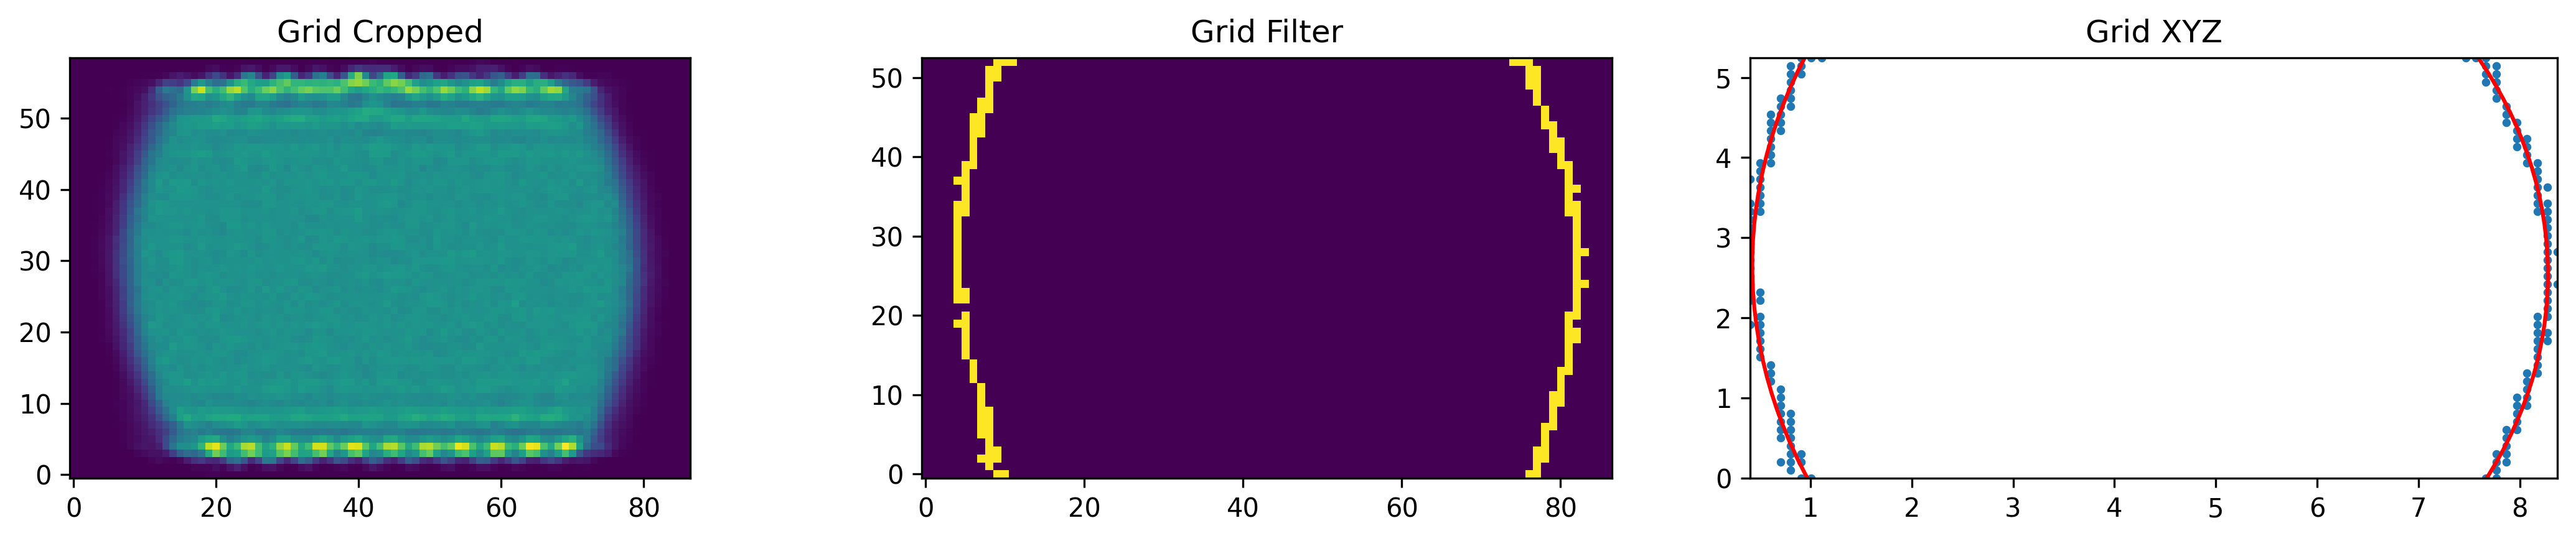

Chunk:  72%|███████▎  | 29/40 [04:19<01:21,  7.45s/it]

114.10532948877348


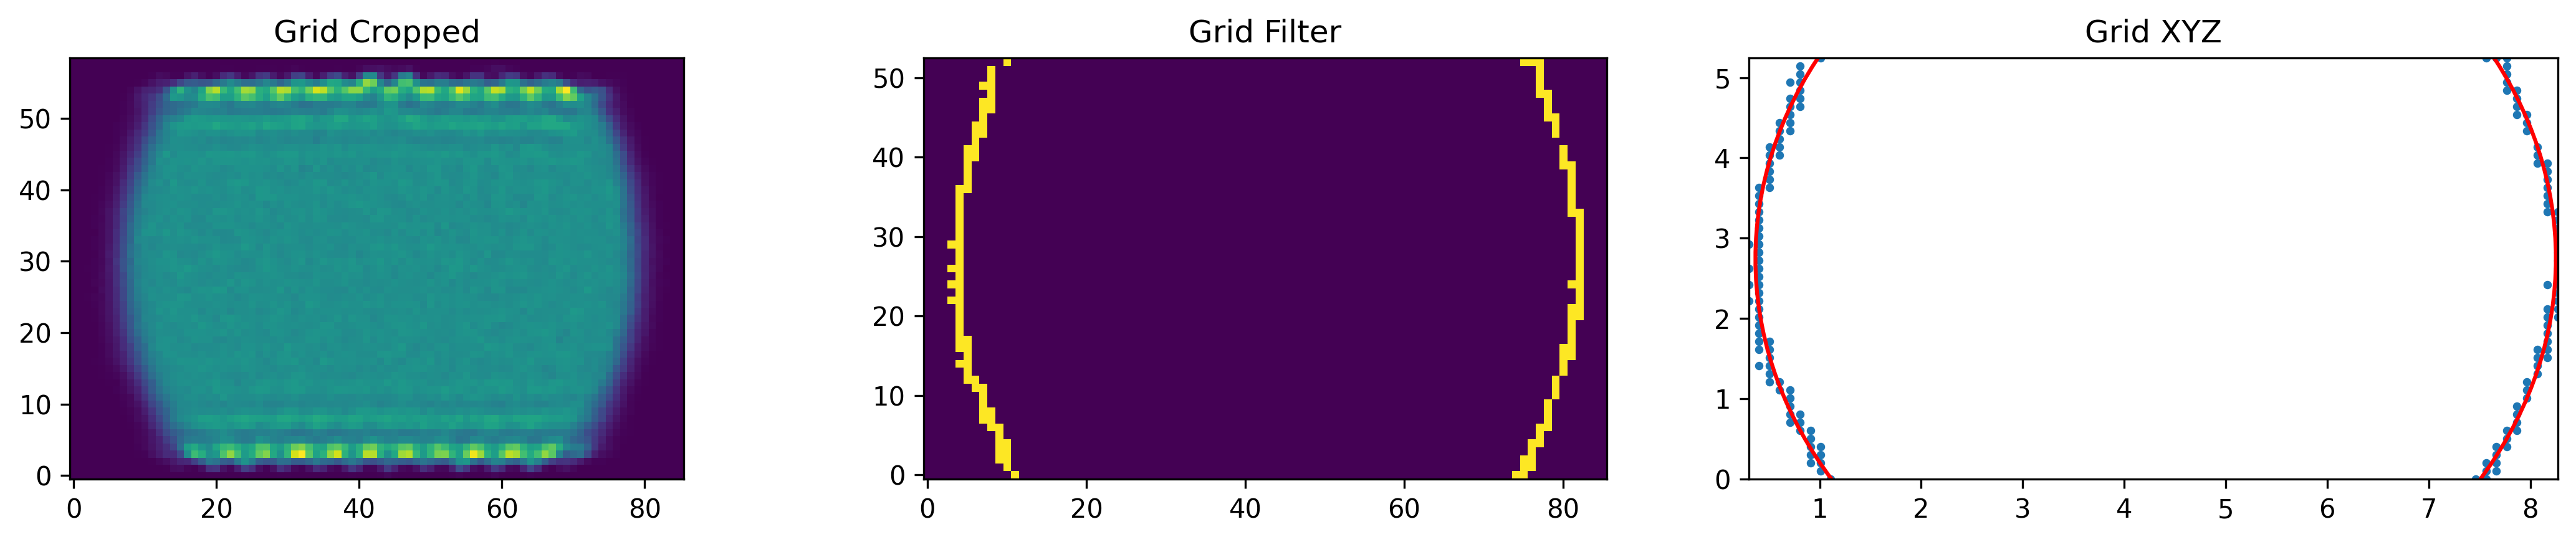

Chunk:  75%|███████▌  | 30/40 [04:27<01:15,  7.53s/it]

119.03624396810812


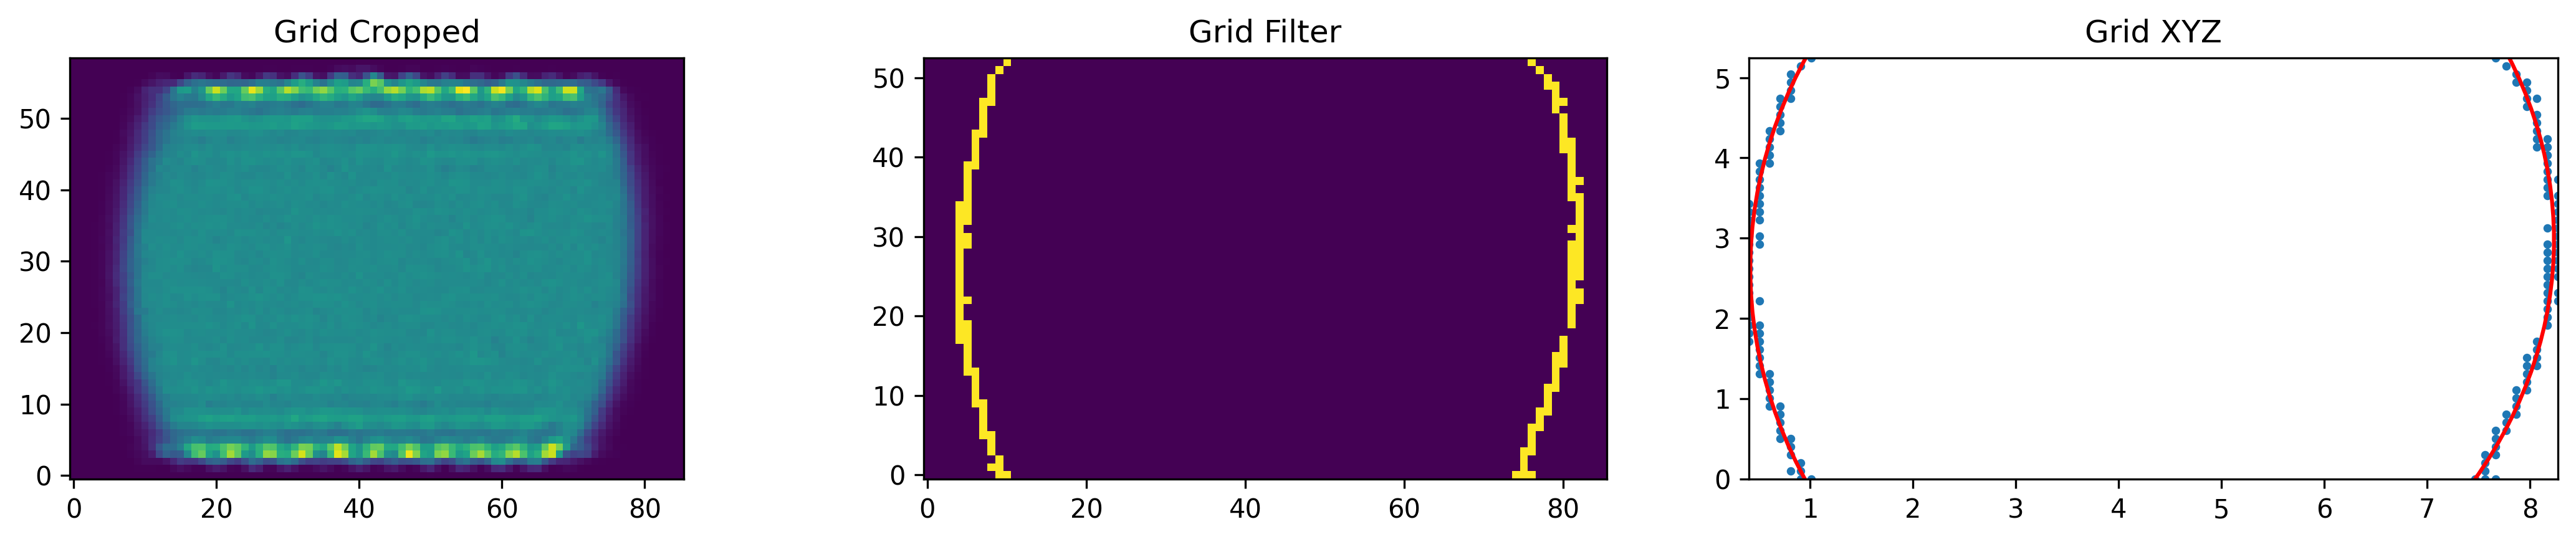

Chunk:  78%|███████▊  | 31/40 [04:35<01:11,  7.92s/it]

113.53460708631945


Chunk:  80%|████████  | 32/40 [04:43<01:02,  7.76s/it]

117.78467670760804


Chunk:  82%|████████▎ | 33/40 [04:51<00:54,  7.77s/it]

118.13022427035527


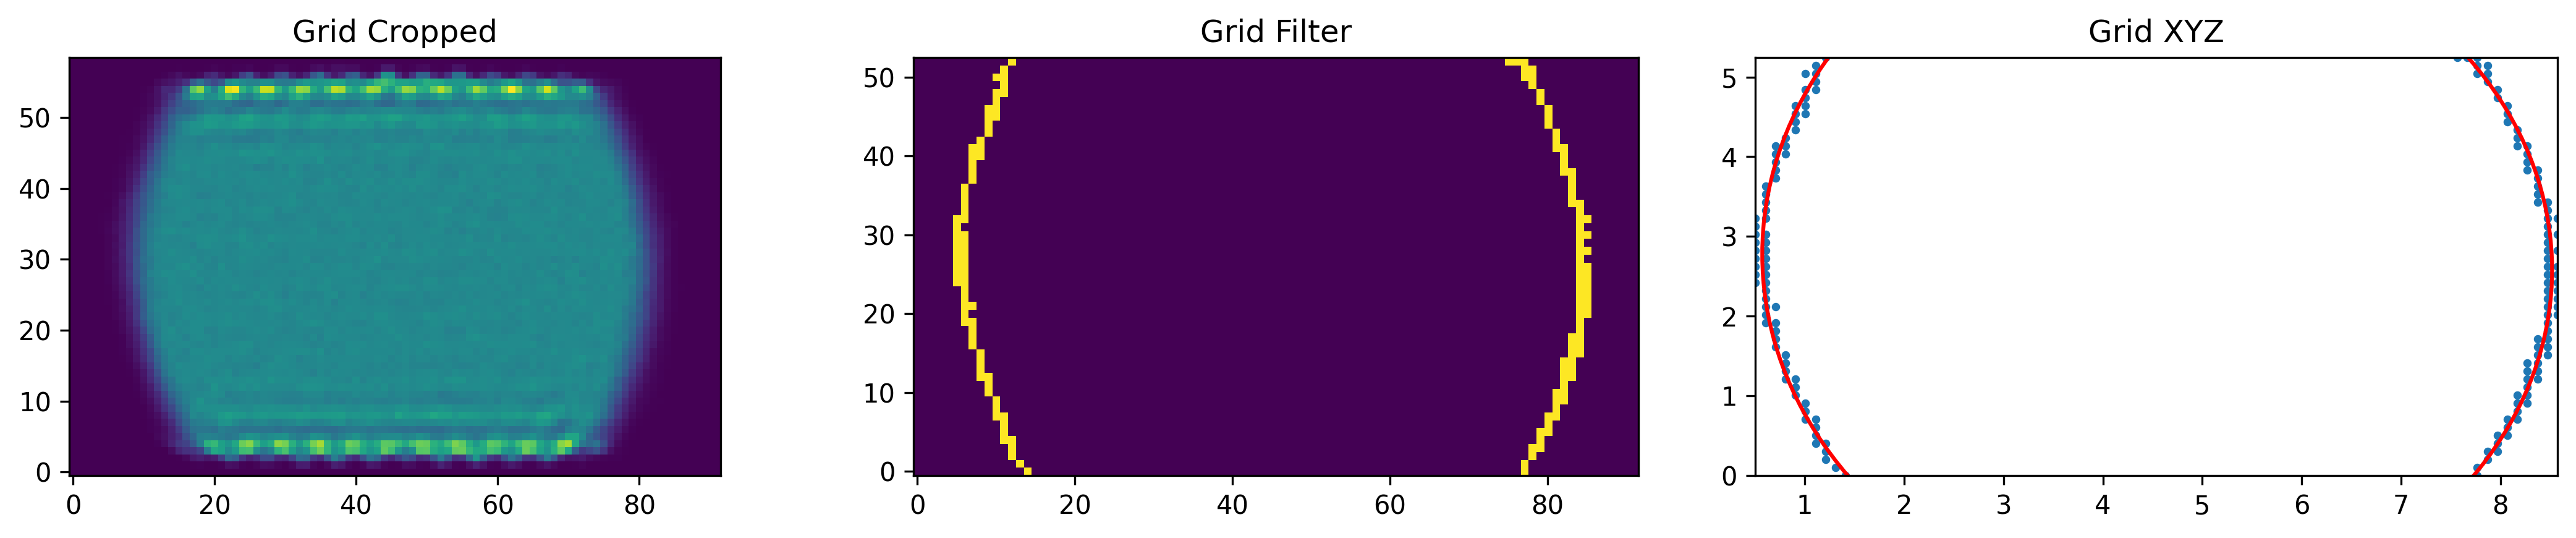

Chunk:  85%|████████▌ | 34/40 [04:59<00:47,  7.88s/it]

122.86016667269573


Chunk:  88%|████████▊ | 35/40 [05:06<00:38,  7.61s/it]

116.32460736357005


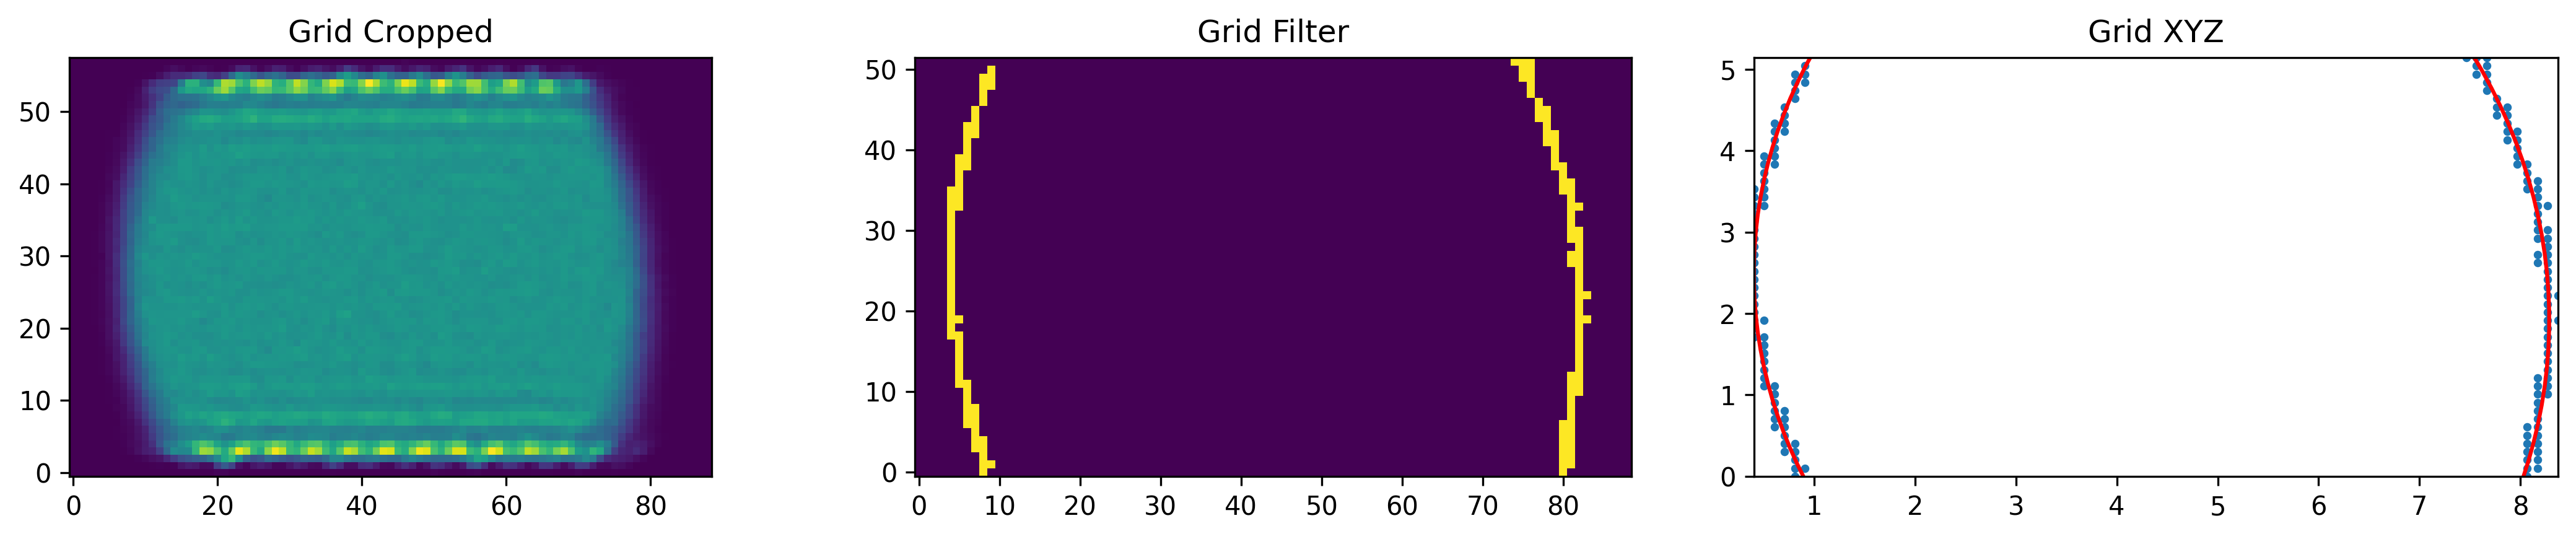

Chunk:  90%|█████████ | 36/40 [05:14<00:30,  7.65s/it]

112.25433117158667


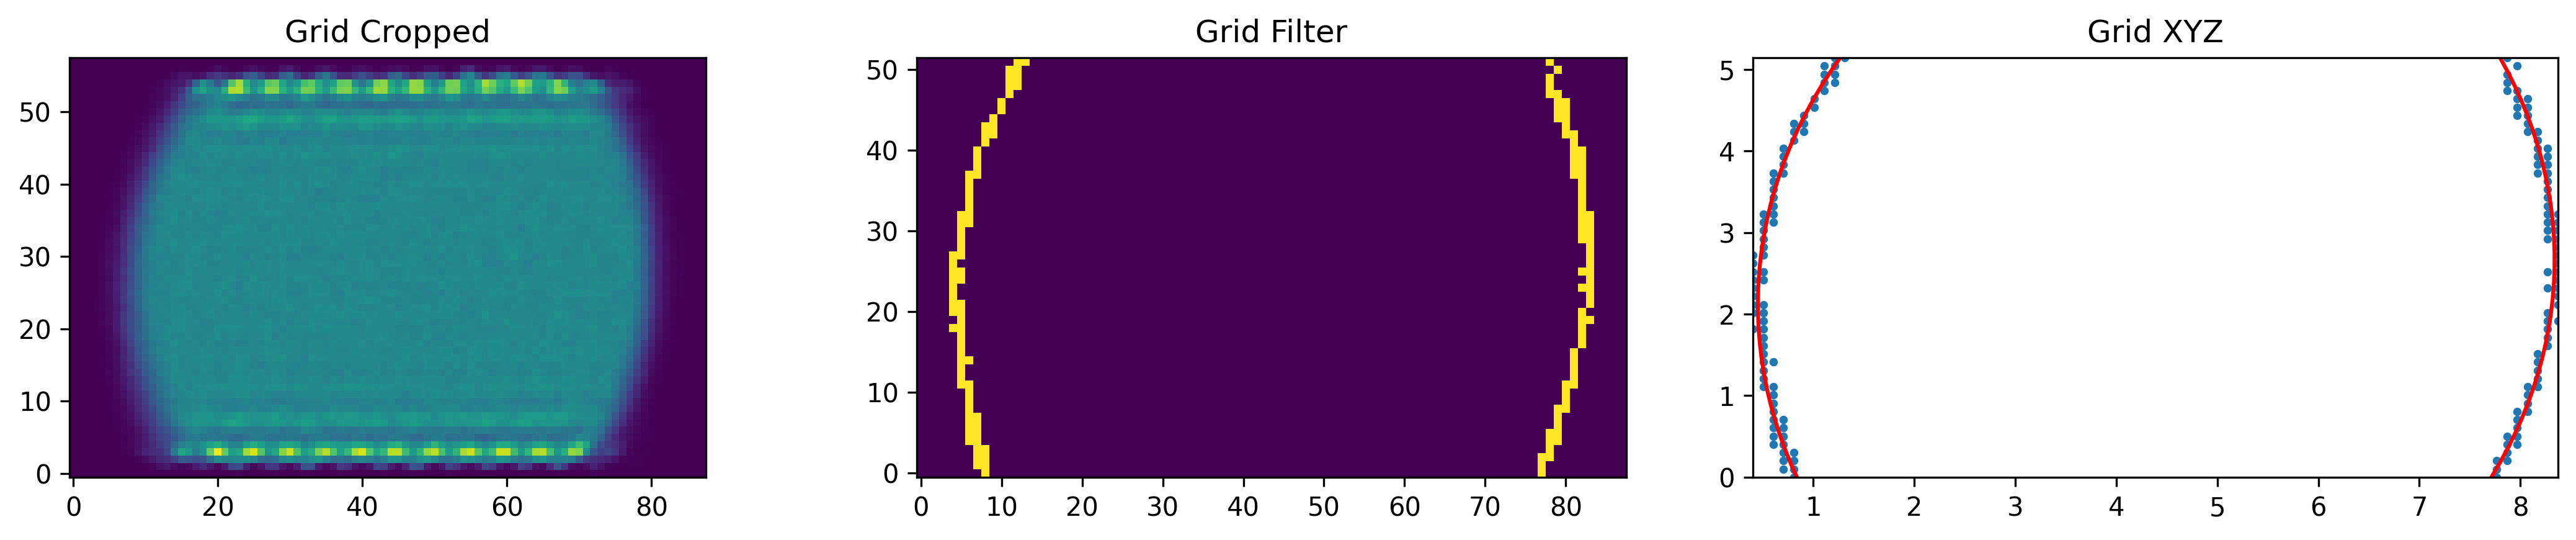

Chunk:  92%|█████████▎| 37/40 [05:21<00:22,  7.49s/it]

115.40440267789198


Chunk:  95%|█████████▌| 38/40 [05:28<00:14,  7.37s/it]

113.51992294957834


Chunk:  98%|█████████▊| 39/40 [05:36<00:07,  7.57s/it]

115.09165583312517


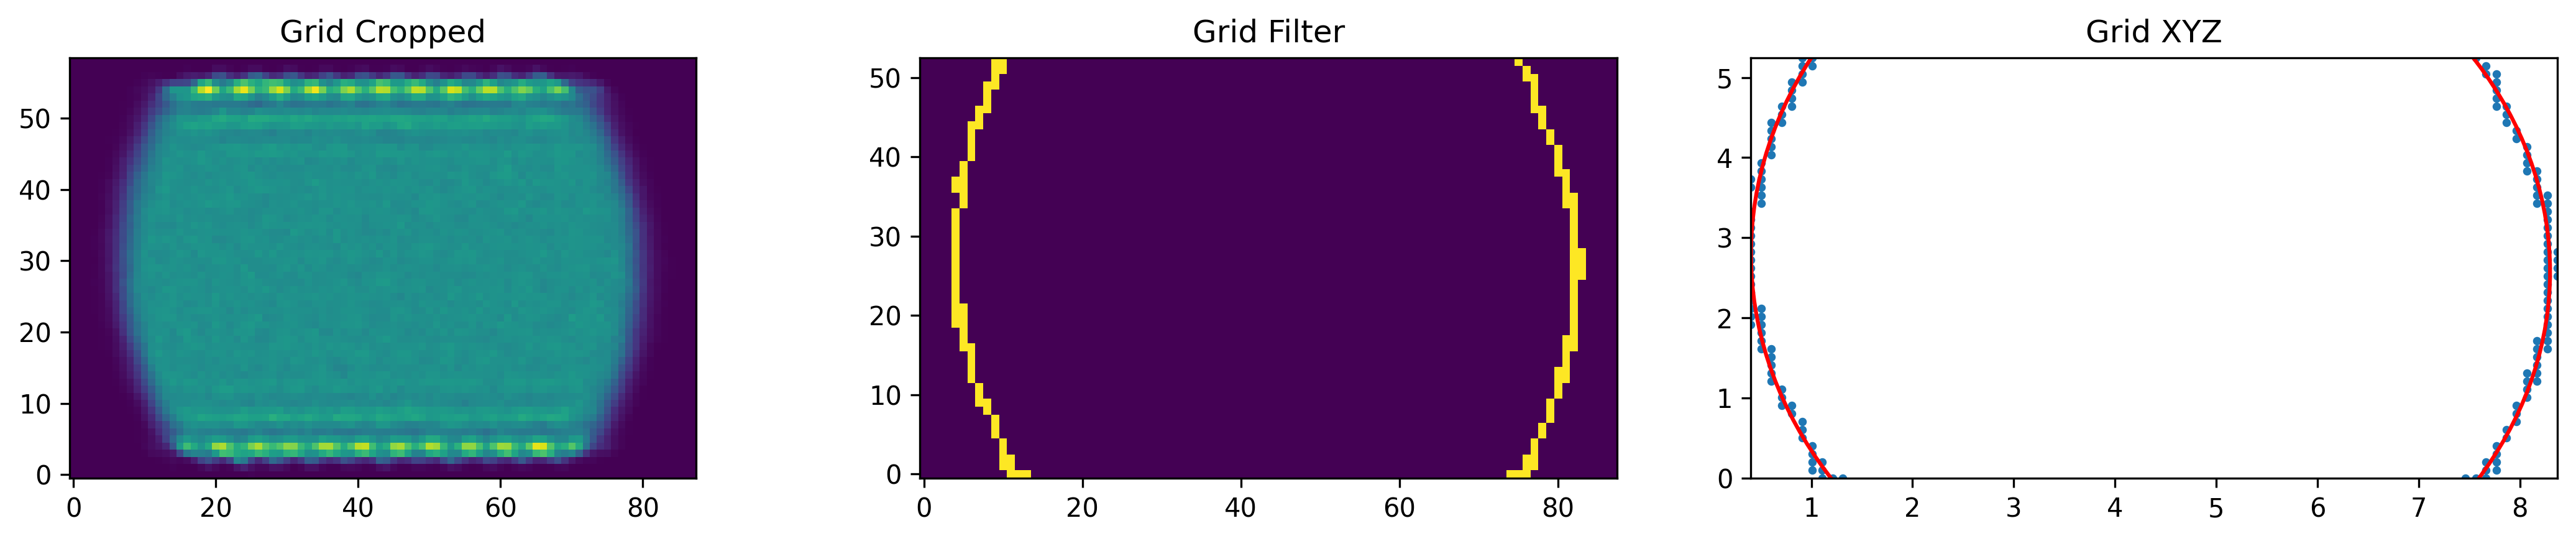

Chunk: 100%|██████████| 40/40 [05:43<00:00,  8.58s/it]

119.86560127789258


In [7]:
type = 'roll'

residue = 'DECAN'
centering_residue = 'WATER'
grid_size = 0.1 # nm
rho_bulk = 3.0896
z_offset = 0.4

timestep = 2
units = "ps"
block_length = 1_000
chunk_length = 1_000
begin_time = 0
time = 20000000 * timestep // 1000

u = 1000 if units.lower() == "ns" else 1
# Calculate the number of frames and chunks
N = int(time * u) // int(timestep * u) + 1
L = int((time - begin_time) * u) // int(block_length * u)
tau = int(block_length * u) // int(timestep * u)
start_frame = N - tau * L

t = np.zeros(L)
angles = np.zeros(L)
delta = np.zeros(L)

angles = []

# Iterate over trajectory chunks
folder = os.path.join(os.environ['HOME'] + f'/PANDA_exp/panda_nn/calcite_decane_water_{type}')
chunk_iter = md.iterload(
    os.path.join(folder, 'cal_dec_tip4p.xtc'),
    top=os.path.join(folder, 'cal_dec_tip4p.gro'),
    chunk=tau, skip=start_frame
)
for chunk_idx, chunk in enumerate(tqdm(chunk_iter, total=L, desc="Chunk")):
    if type in ['droplet', 'perforation', 'doughnut']:
        NR, NZ = (max(chunk.unitcell_lengths[0, 0], chunk.unitcell_lengths[0, 1]) / grid_size).astype(int) // 2, (chunk.unitcell_lengths[0, 2].astype(int) / grid_size).astype(int)
        centering_residue = 'WATER' if type == 'perforation' else residue
        r, z, grid, dr, dz = density_plane_cylindric(chunk, residue, NR, NZ, centering_residue_name=centering_residue, begin=0, center=True)
    else:
        NX, NY, NZ = (chunk.unitcell_lengths[0, :3] / grid_size).astype(int)
        x, z, grid, dx, dz = density_plane(chunk, residue, NX, NZ, begin=0, center=True)

    grid_cropped = cropp_grid(grid)

    simmetric = False if type in ['droplet', 'worm'] else True
    grid_offset, N_offset = make_offset(grid_cropped, z_offset, dz, simmetric=simmetric)

    eps = 0.3
    grid_filter = np.abs(grid_offset / rho_bulk - 0.5) < eps

    # Create figure with 3 subplots
    scale = 1.2
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*4*scale, 2.5*scale), dpi=300)

    # Plot grid_cropped
    ax1.imshow(grid_cropped.T, origin='lower')
    ax1.set_title('Grid Cropped')

    # Plot grid_filter
    ax2.imshow(grid_filter.T, origin='lower')
    ax2.set_title('Grid Filter')

    # Plot grid_xyz
    if type in ['droplet', 'worm']:
        grid_xyz = grid2xyz(grid_filter, dr, dz)
        xc, zc, r, sigma = taubinSVD(grid_xyz)

        ax3.scatter(grid_xyz[:, 0], grid_xyz[:, 1], s=5)
        angle = np.linspace(np.deg2rad(-60), np.deg2rad(240), 100)
        ax3.plot(xc + r * np.cos(angle), zc + r * np.sin(angle), color='red')

        # Set axis limits to data bounds
        ax3.set_xlim([np.min(grid_xyz[:, 0]), np.max(grid_xyz[:, 0])])
        ax3.set_ylim([np.min(grid_xyz[:, 1]), np.max(grid_xyz[:, 1])])
    else:
        if type in ['doughnut', 'perforation']:
            grid_xyz = grid2xyz(grid_filter, dr, dz)
        else:
            grid_xyz = grid2xyz(grid_filter, dx, dz)
        lx, lz = np.max(grid_xyz, axis=0)
        left_grid_xyz = grid_xyz[grid_xyz[:, 0] < lx / 2, :]
        right_grid_xyz = grid_xyz[grid_xyz[:, 0] > lx / 2, :]

        xc_left, zc_left, r_left, sigma_left = taubinSVD(left_grid_xyz)
        xc_right, zc_right, r_right, sigma_right = taubinSVD(right_grid_xyz)

        ax3.scatter(grid_xyz[:, 0], grid_xyz[:, 1], s=5)
        angle_left = np.linspace(np.deg2rad(90), np.deg2rad(270), 100)
        ax3.plot(xc_left + r_left * np.cos(angle_left), zc_left + r_left * np.sin(angle_left), color='red')
        angle_right = np.linspace(np.deg2rad(-90), np.deg2rad(90), 100)
        ax3.plot(xc_right + r_right * np.cos(angle_right), zc_right + r_right * np.sin(angle_right), color='red')

        # Set axis limits to data bounds
        ax3.set_xlim([np.min(grid_xyz[:, 0]), np.max(grid_xyz[:, 0])])
        ax3.set_ylim([np.min(grid_xyz[:, 1]), np.max(grid_xyz[:, 1])])

    ax3.set_title('Grid XYZ')
    plt.tight_layout()
    plt.show()

    # Without extropolation
    if type in ['droplet', 'worm']:
        x_bottom_left = -np.sqrt(r**2 - zc**2) + xc
        angle_bottom_left = np.pi / 2 + np.arctan(np.abs(zc) / np.abs(xc - x_bottom_left))

        x_bottom_right = np.sqrt(r**2 - zc**2) + xc
        angle_bottom_right = np.pi / 2 + np.arctan(np.abs(zc) / np.abs(xc - x_bottom_right))

        print(np.rad2deg(angle_bottom_left + angle_bottom_right) / 2)
        angles.append(np.rad2deg(angle_bottom_left + angle_bottom_right) / 2)

    else:
        x_top_left = -np.sqrt(r_left**2 - (lz - zc_left)**2) + xc_left
        angle_top_left = np.pi / 2 + np.arctan(np.abs(lz - zc_left) / np.abs(xc_left - x_top_left))
        x_bottom_left = -np.sqrt(r_left**2 - (zc_left)**2) + xc_left
        angle_bottom_left = np.pi / 2 + np.arctan(np.abs(zc_left) / np.abs(xc_left - x_bottom_left))

        x_top_right = np.sqrt(r_right**2 - (lz - zc_right)**2) + xc_right
        angle_top_right = np.pi / 2 + np.arctan(np.abs(lz - zc_right) / np.abs(xc_right - x_top_right))
        x_bottom_right = np.sqrt(r_left**2 - (zc_right)**2) + xc_right
        angle_bottom_right = np.pi / 2 + np.arctan(np.abs(zc_right) / np.abs(xc_right - x_bottom_right))

        print(np.rad2deg(angle_bottom_left + angle_top_left + angle_top_right + angle_bottom_right) / 4)
        angles.append(np.rad2deg(angle_bottom_left + angle_top_left + angle_top_right + angle_bottom_right) / 4)

In [52]:
worm_angles = angles

In [21]:
print(angles)

[105.49064006228274, 119.06892394921458, 123.82539071247608, 121.36797016979284, 125.9580353785649, 120.21572733734578, 122.87188094936361, 129.9662498631864, 129.01121973112666, 125.91484739639117, 123.35210720655306, 121.43751489336181, 128.5218264276733, 121.4161782666617, 120.48876471565876, 125.01288422843939, 117.64353020572005, 120.72225644735813, 121.24667174131221, 121.99019481342495, 121.82929562756867, 130.65154147142317, 123.21214377144788, 122.10050172639936, 128.21834516489304, 124.05548253961817, 124.63329081775677, 124.96152673178247, 124.60801548632625, 124.12633283035724, 118.29233616317696, 127.30690251770207, 122.80047180619832, 121.16726214859636, 126.98593296970984, 123.49761594279805, 124.69449363375413, 131.1163604157906, 115.79925500888419, 124.21376265512778]


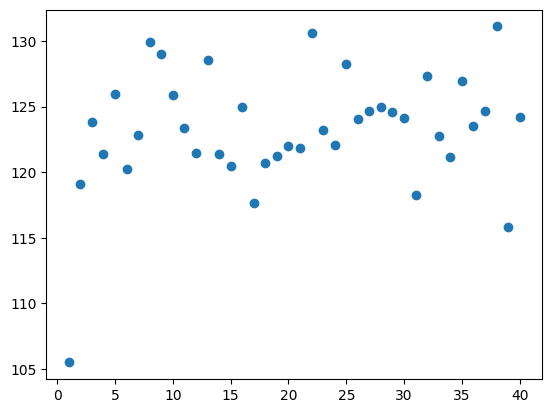

In [22]:
plt.scatter(range(1, 41), angles)

In [12]:
x, z, grid, dx, dz = density_plane(chunk, 'DECAN', NX, NZ, begin=0, center=True)

In [30]:
r, z, grid, dr, dz = density_plane_cylindric(chunk, 'DECAN', NX, NZ, begin=0, center=True)

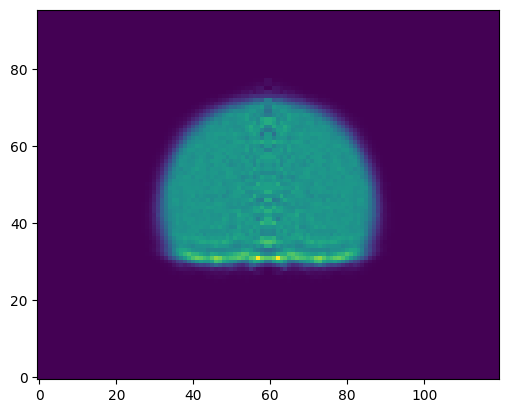

In [31]:
plt.imshow(grid.T, origin='lower')
plt.show()

In [ ]:
# folder = os.path.join('synthetic', '120', 'roll')
folder = os.path.join(os.environ['HOME'] + '/PANDA_exp/panda_nn/calcite_decane_water_droplet')

# u = mda.Universe(*[os.path.join(folder, f'{i}.gro') for i in range(1, 101)])
# u = mda.Universe(os.path.join(folder, 'cal_dec_tip4p.xtc'), os.path.join(folder, 'cal_dec_tip4p.gro'))
u = md.load(os.path.join(folder, 'cal_dec_tip4p.xtc'), top=os.path.join(folder, 'cal_dec_tip4p.gro'))

In [12]:
grid_size = 1 # Angstrom

NX, NY, NZ = (u.dimensions[:3] / grid_size).astype(int)

In [24]:
u.atoms.residues[0]

<Residue>

In [85]:
x, z, grid, dx, dz = density_plane(u, 'DECAN', NX, NZ, begin=0, center=True)

AttributeError: 'int' object has no attribute 'n_frames'

In [33]:
rho_bulk = 3.0896
zc = 0

In [46]:
grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
grid[60, 40]

13.42446

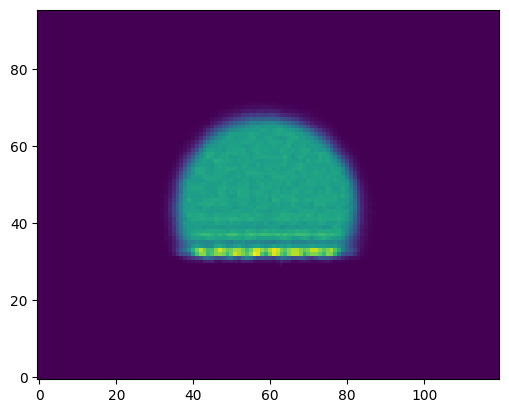

In [25]:
plt.imshow(grid.T, origin='lower')

4.0

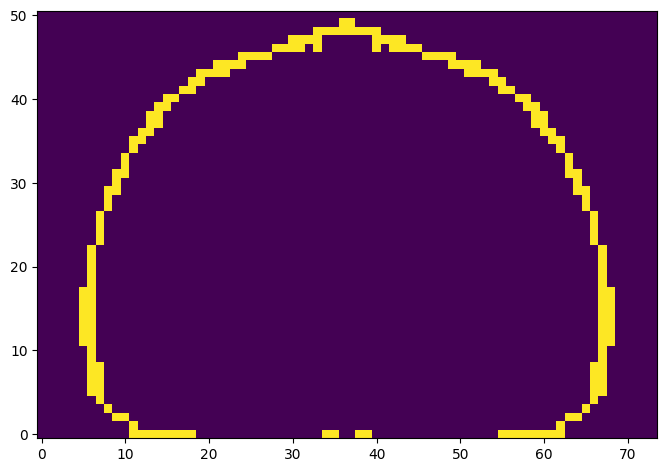

In [36]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 12))
plt.figure(figsize=(8, 6))

grid_cropped = cropp_grid(grid)
grid_offset, N_offset = make_offset(grid_cropped, 0.5, dz, simmetric=False)

eps = 0.3
grid_filter = np.abs(grid_offset / rho_bulk - 0.5) < eps

# plt.imshow(grid.T, origin='lower')
# plt.imshow(grid_cropped.T, origin='lower')
# plt.imshow(grid_offset.T, origin='lower')
plt.imshow(grid_filter.T, origin='lower')
# grid_cropped
# ax[1].imshow(border.T)
plt.show()

In [11]:
grid_xyz = grid2xyz(grid_filter, dx, dz)

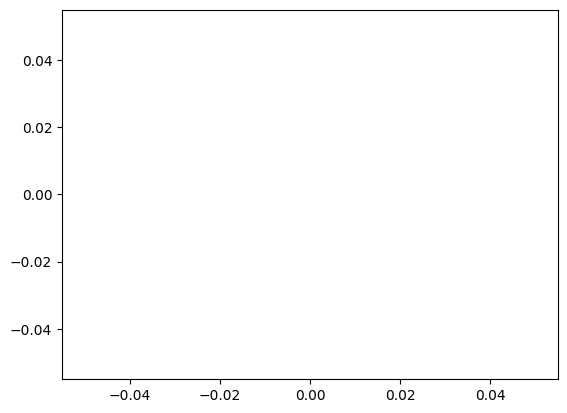

In [41]:
plt.scatter(grid_xyz[:, 0], grid_xyz[:, 1], s=5)

In [13]:
lx, lz = np.max(grid_xyz, axis=0)
left_grid_xyz = grid_xyz[grid_xyz[:, 0] < lx / 2, :]
right_grid_xyz = grid_xyz[grid_xyz[:, 0] > lx / 2, :]

In [14]:
xc_left, zc_left, r_left, sigma_left = taubinSVD(grid_xyz)
# xc_left, zc_left, r_left, sigma_left = taubinSVD(left_grid_xyz)
# xc_right, zc_right, r_right, sigma_right = taubinSVD(right_grid_xyz)

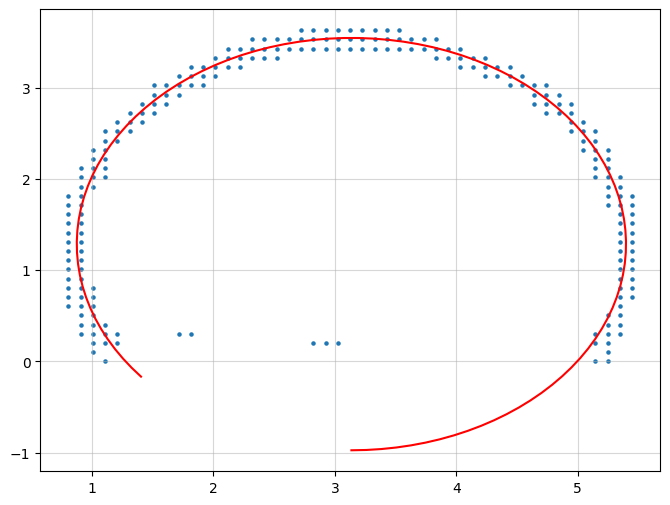

In [15]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

plt.scatter(grid_xyz[:, 0], grid_xyz[:, 1], s=5)

angle_left = np.linspace(np.deg2rad(-90), np.deg2rad(220), 100)
plt.plot(xc_left + r_left * np.cos(angle_left), zc_left + r_left * np.sin(angle_left), color='red')

# angle_right = np.linspace(np.deg2rad(-80), np.deg2rad(100), 100)
# plt.plot(xc_right + r_right * np.cos(angle_right), zc_right + r_right * np.sin(angle_right), color='red')

In [109]:
LX, LZ = np.array(grid_cropped.shape) * np.array([dx, dz])
lx, lz = np.array(grid_offset.shape) * np.array([dx, dz])

dz = N_offset * dz

In [110]:
# Without extropolation
x_top_left = -np.sqrt(r_left**2 - (lz - zc_left)**2) + xc_left
angle_top_left = np.pi / 2 + np.arctan(np.abs(lz - zc_left) / np.abs(xc_left - x_top_left))
x_bottom_left = -np.sqrt(r_left**2 - (zc_left)**2) + xc_left
angle_bottom_left = np.pi / 2 + np.arctan(np.abs(zc_left) / np.abs(xc_left - x_bottom_left))

x_top_right = np.sqrt(r_right**2 - (lz - zc_right)**2) + xc_right
angle_top_right = np.pi / 2 + np.arctan(np.abs(lz - zc_right) / np.abs(xc_right - x_top_right))
x_bottom_right = np.sqrt(r_left**2 - (zc_right)**2) + xc_right
angle_bottom_right = np.pi / 2 + np.arctan(np.abs(zc_right) / np.abs(xc_right - x_bottom_right))

In [111]:
print(
    np.rad2deg(angle_bottom_left),
    np.rad2deg(angle_top_left),
    np.rad2deg(angle_top_right),
    np.rad2deg(angle_bottom_right),
    sep='\n'
)

99.23489012143035
98.23286782470603
98.78093380481754
97.56722137998123


In [102]:
print(np.rad2deg(angle_bottom_left + angle_top_left + angle_top_right + angle_bottom_right) / 4)

97.61277264186086


---

In [85]:
plt.rcParams['font.family'] = 'Helvetica'

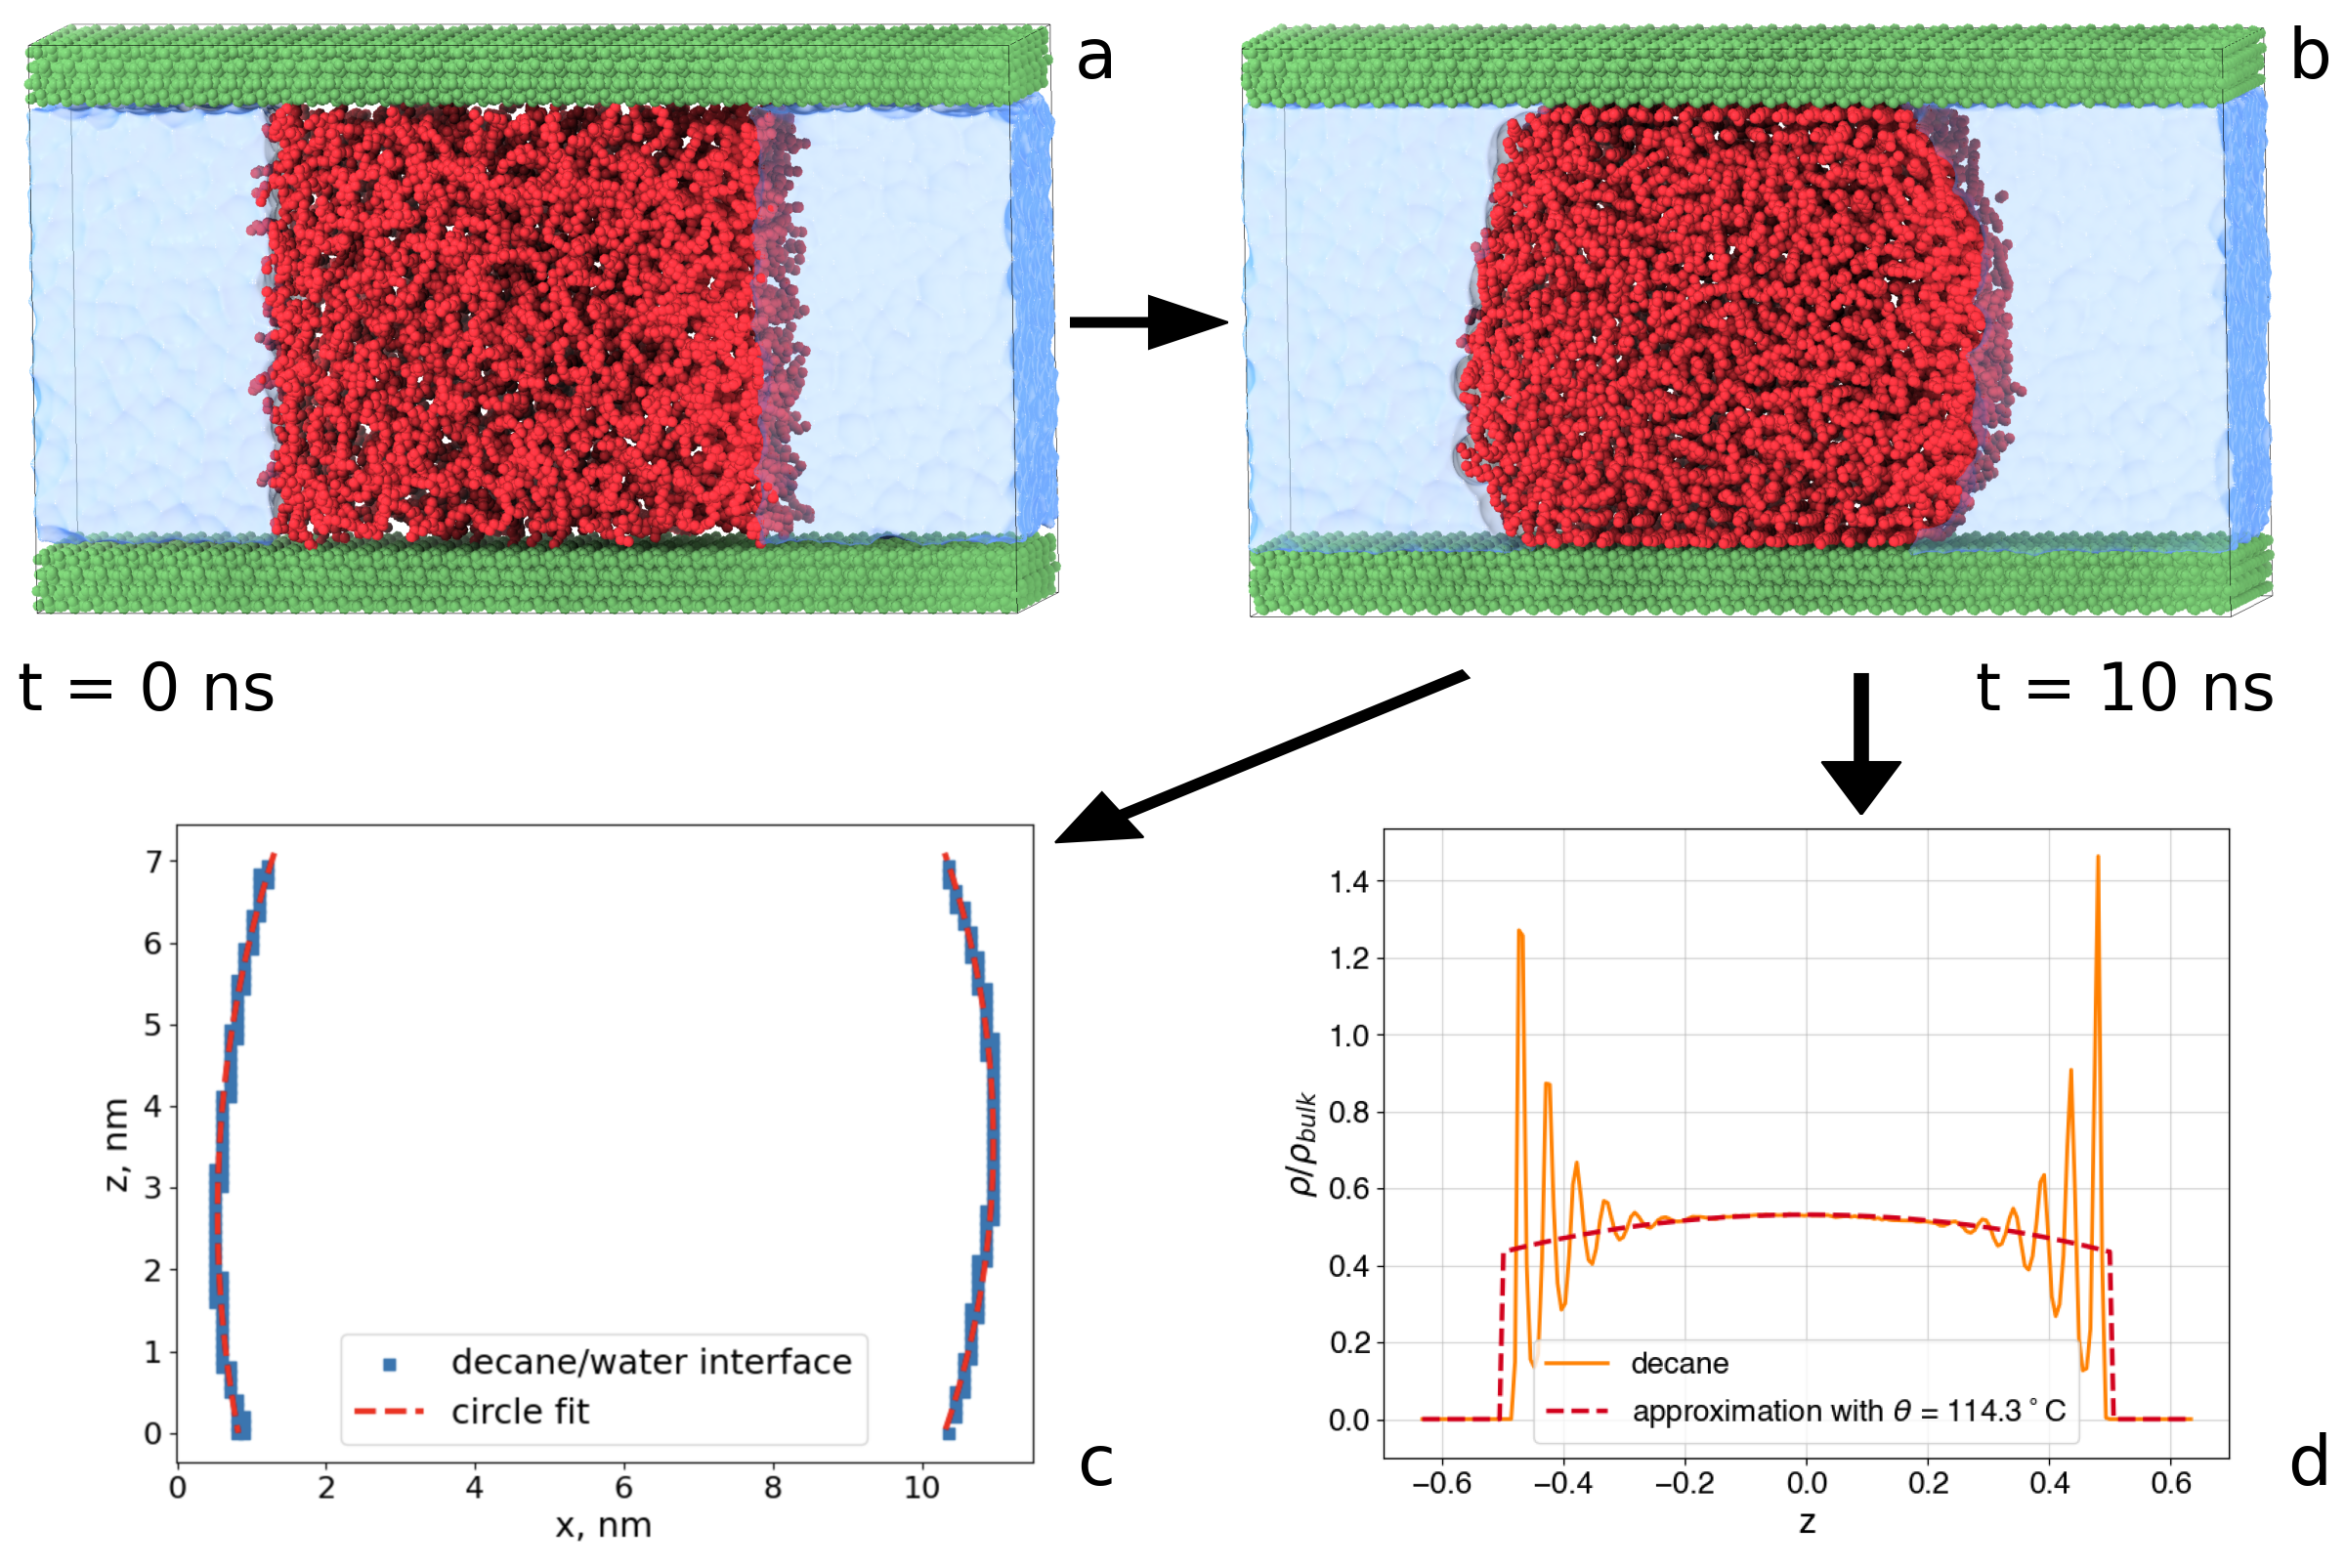

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the four images
# img1 = mpimg.imread('calcite_decane_water_init.png')  # Replace with your first image path
# img2 = mpimg.imread('calcite_decane_water.png')  # Replace with your second image path
img1 = mpimg.imread('cal_decane_init.png')  # Replace with your first image path
img2 = mpimg.imread('cal_decane.png')  # Replace with your second image path
img3 = mpimg.imread('calcite_decane_water_angle_approx.png')  # Replace with your third image path
img4 = mpimg.imread('calcite_decane_water_profile_approx.png')  # Replace with your fourth image path

# Create a new figure
fig, ax = plt.subplots(figsize=(18, 12), dpi=150)
plt.axis('off')  # Turn off the axis for the main plot as well

# Define positions for the four subplots
positions = [(0.05, 0.55, 0.4, 0.4),  # Top-left image (t = 0 ps)
             (0.51, 0.55, 0.4, 0.4),  # Top-right image (t = 10 ps)
             (0.05, 0.05, 0.42, 0.42),  # Bottom-left plot
             (0.5, 0.05, 0.42, 0.42)]  # Bottom-right plot

# Images to plot
images = [img1, img2, img3, img4]

# Add each image to the figure in the defined positions
for i, (pos, img) in enumerate(zip(positions, images)):
    ax_inset = fig.add_axes(pos)
    ax_inset.imshow(img)
    ax_inset.axis('off')

# Draw arrows
# plt.arrow(0.44, 0.55, 0.05, 0, width=0.001, head_width=0.01, head_length=0.01, fc='black', ec='black')
# plt.arrow(0.32, 0.52, -0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')
# plt.arrow(0.68, 0.52, 0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')

ax.arrow(0.4, 0.75, 0.08, 0, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
ax.arrow(0.6, 0.55, -0.13, -0.08, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
ax.arrow(0.75, 0.55, 0, -0.05, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)

# Add text annotations
ax.text(0.1, 0.54, "t = 0 ns", fontsize=32, ha='center', va='center', transform=fig.transFigure)
ax.text(0.85, 0.54, "t = 10 ns", fontsize=32, ha='center', va='center', transform=fig.transFigure)

# Add labels (a, b, c, d) in the bottom right corner of each image
label_positions = [(0.46, 0.9),  # Bottom-right corner of the top-left image
                   (0.92, 0.9),  # Bottom-right corner of the top-right image
                   (0.46, 0.1),  # Bottom-right corner of the bottom-left image
                   (0.92, 0.1)]  # Bottom-right corner of the bottom-right image

labels = ['a', 'b', 'c', 'd']

# Add each label to the figure
for label, (x, y) in zip(labels, label_positions):
    fig.text(x, y, label, fontsize=34, ha='center', va='center', transform=fig.transFigure)


# plt.savefig('steps.png', dpi=150)
plt.show()


In [133]:
0.002 * 20000000

40000.0